<a href="https://colab.research.google.com/github/zambbo/CNN-DialectDetector/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import os
import re
from matplotlib import pyplot as plt
from glob import glob
import numpy as np
import pickle
from tqdm import tqdm
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
index2region={0:'gangwon', 1:'gyeongsang', 2:'jeonla', 3:'chungcheong', 4:'jeju'}
region2index = {v:k for k,v in index2region.items()}
region_shortening = ['GW','GS','JL','CC','JJ']
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# 데이터 셋 구성 (small dataset)
dataset_dir = '/content/drive/MyDrive/DialectDataset/small_dataset/'

In [5]:
region_dir = glob(dataset_dir)
region_dir

['/content/drive/MyDrive/DialectDataset/small_dataset/']

In [6]:
for k, v in index2region.items():
    exec(f"{v}_dirs = glob(dataset_dir+'*_{v}/*')")
jeonla_dirs

['/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000014',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000012',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000019',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000006',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000015',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000032',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000027',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000018',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000005',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000024']

In [7]:
def make_tuple_data(dirs, max_num):
    for i, region_dir in enumerate(dirs):
        if i>=max_num:break
        spectro_path = glob(region_dir+'/*_spectro.pickle')[0]
        mfcc_path = glob(region_dir+'/*_mfcc.pickle')[0]
        chroma_path = glob(region_dir+'/*_chroma.pickle')[0]
        
        with open(spectro_path, "rb") as f:
            spectro = pickle.load(f)
        with open(mfcc_path, "rb") as f:
            mfcc = pickle.load(f)
        with open(chroma_path, "rb") as f:
            chroma = pickle.load(f)

        if i == 0:
            spectro_data = spectro
            mfcc_data = mfcc
            chroma_data = chroma
        else:
            spectro_data = np.concatenate([spectro_data,spectro], axis=0)
            mfcc_data = np.concatenate([mfcc_data,mfcc], axis=0)
            chroma_data = np.concatenate([chroma_data,chroma], axis=0)
    if max_num ==0:return []
        
    r_data = [(s,m,c) for s,m,c in zip(spectro_data,mfcc_data,chroma_data)]
        
    return r_data

def make_tuple(max_num=2):
    jeonla_data = make_tuple_data(jeonla_dirs, max_num)
    chungcheong_data = make_tuple_data(chungcheong_dirs, max_num)
    gyeongsang_data = make_tuple_data(gyeongsang_dirs, max_num)
    jeju_data = make_tuple_data(jeju_dirs, max_num)
    gangwon_data = make_tuple_data(gangwon_dirs, max_num)
    return jeonla_data, chungcheong_data, gyeongsang_data, jeju_data, gangwon_data

def print_data(r_data, region):
    if len(r_data)==0: return
    print(f"{region} data num: ", len(r_data))
    print(f"{region} tuple size", len(r_data[0]))
    print(f"{region} spec shape", r_data[0][0].shape)

jeonla_data, chungcheong_data, gyeongsang_data, jeju_data, gangwon_data = make_tuple(10)
print_data(jeonla_data, 'jeonla')
print_data(chungcheong_data, 'chungcheong')
print_data(gyeongsang_data, 'gyeongsang')
print_data(jeju_data, 'jeju')
print_data(gangwon_data, 'gangwon')

jeonla data num:  913
jeonla tuple size 3
jeonla spec shape (201, 501)
chungcheong data num:  1108
chungcheong tuple size 3
chungcheong spec shape (201, 501)
gyeongsang data num:  842
gyeongsang tuple size 3
gyeongsang spec shape (201, 501)
jeju data num:  756
jeju tuple size 3
jeju spec shape (201, 501)
gangwon data num:  1183
gangwon tuple size 3
gangwon spec shape (201, 501)


In [8]:
jeonla_data_l = []
for data in jeonla_data:
    y = [0,0,0,0,0]
    y[region2index['jeonla']] = 1
    jeonla_data_l.append((data,y))

chungcheong_data_l = []
for data in chungcheong_data:
    y = [0,0,0,0,0]
    y[region2index['chungcheong']] = 1
    chungcheong_data_l.append((data,y))

gyeongsang_data_l = []
for data in gyeongsang_data:
    y = [0,0,0,0,0]
    y[region2index['gyeongsang']] = 1
    gyeongsang_data_l.append((data,y))

jeju_data_l = []
for data in jeju_data:
    y = [0,0,0,0,0]
    y[region2index['jeju']] = 1
    jeju_data_l.append((data,y))

gangwon_data_l = []
for data in gangwon_data:
    y = [0,0,0,0,0]
    y[region2index['gangwon']] = 1
    gangwon_data_l.append((data,y))

In [9]:
datasumup = np.concatenate([jeonla_data_l, chungcheong_data_l, gangwon_data_l, jeju_data_l, gyeongsang_data_l], axis=0)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [10]:
print(len(jeonla_data))
print(len(jeonla_data[0]))
print(len(jeonla_data[0][0]))
print(jeonla_data[0][0][0].shape)
print(jeonla_data[0][1])

913
3
201
(501,)
[[-803.2581 -803.2581 -803.2581 ... -803.2581 -803.2581 -803.2581]
 [   0.        0.        0.     ...    0.        0.        0.    ]
 [   0.        0.        0.     ...    0.        0.        0.    ]
 ...
 [   0.        0.        0.     ...    0.        0.        0.    ]
 [   0.        0.        0.     ...    0.        0.        0.    ]
 [   0.        0.        0.     ...    0.        0.        0.    ]]


In [11]:
from sklearn.preprocessing import normalize
class MultiModalDataset(Dataset):

    def __init__(self, data):

        self.data = data

    def __getitem__(self, idx):
        datas, label = self.data[idx]
        spec, mfcc, chroma = datas
        spec, mfcc, chroma = normalize(spec), normalize(mfcc), normalize(chroma)
        spec, mfcc, chroma = torch.tensor(spec, dtype=torch.float32), torch.tensor(mfcc, dtype=torch.float32), torch.tensor(chroma, dtype=torch.float32)
        spec, mfcc, chroma = spec.unsqueeze(0), mfcc.unsqueeze(0), chroma.unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32)

        data = (spec, mfcc, chroma)
        return data, label
    
    def __len__(self):
        return len(self.data)

In [12]:
dataset = MultiModalDataset(datasumup)
len(dataset)

4802

In [13]:
class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.seq1 = nn.Sequential(self.conv1, self.bn1, self.relu)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.seq2 = nn.Sequential(self.conv2, self.bn2)
        
        self.down_flag = False
        if in_channels != out_channels: self.down_flag = True

        self.downsample = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1,1), stride=2, padding=0, bias=False)
    
    def forward(self, x):
        #print(x.shape)
        y = self.seq1(x)
        #print(y.shape)
        y = self.seq2(y)
        #print(y.shape)

        if self.down_flag:
            x = self.downsample(x)
        
        y = self.relu(y)
        #print(x.shape)
        #print(y.shape)
        y = y + x

        return y
        

In [14]:
class ResNet18(nn.Module):

    def __init__(self, in_channels, output_dim=256, model_type='spec'):
        super(ResNet18, self).__init__()

        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(7,7), stride=2, padding=3)
        self.BN1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=(3,3), stride=2, padding=1)

        self.seq1 = nn.Sequential(self.conv1, self.BN1, self.pool1)

        self.seq2 = nn.Sequential(BasicBlock(64,64), BasicBlock(64,64))
        self.seq3 = nn.Sequential(BasicBlock(64,64), BasicBlock(64, 128, stride=2))
        self.seq4 = nn.Sequential(BasicBlock(128,128), BasicBlock(128,128))
        self.seq5 = nn.Sequential(BasicBlock(128,128), BasicBlock(128,256,stride=2))

        self.avg_pool1 = nn.AdaptiveAvgPool2d((1,1))
        # if model_type=='spec':
        #     self.fc1 = nn.Linear(256*13*32, output_dim)
        # elif model_type=='mfcc':
        #     self.fc1 = nn.Linear(256*7*32, output_dim)
        # elif model_type=='chroma':
        #     self.fc1 = nn.Linear(256*1*32, output_dim)
        self.fc1 = nn.Linear(256, output_dim)


        self.lastlayer = nn.Sequential(self.fc1, self.relu)

    def forward(self, x):
        y = self.seq1(x)
        y = self.seq2(y)
        y = self.seq3(y)
        y = self.seq4(y)
        y = self.seq5(y)
        y = self.avg_pool1(y)
        y = y.view(y.shape[0],-1)
        y = self.lastlayer(y)

        return y



In [17]:
class MultiModalDialectClassifier(nn.Module):

    def __init__(self, hidden_dim=1024, out_dim=5, learning_rate=0.01, best_model_save_path="./best_model.pt"):
        super(MultiModalDialectClassifier, self).__init__()

        self.best_model_save_path = best_model_save_path
        self.spec_res = ResNet18(1, model_type='spec')
        self.mfcc_res = ResNet18(1, model_type='mfcc')
        self.chroma_res = ResNet18(1, model_type='chroma')
        

        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(256*3, 256)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256,64)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, out_dim)
        self.lastlayer = nn.Sequential(self.fc1, self.dropout1, self.relu, self.fc2, self.dropout2, self.relu, self.fc3)

        self.loss_f = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(self.parameters(), lr=learning_rate)
        #self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        spec_x, mfcc_x, chroma_x = x

        spec_y = self.spec_res(spec_x)
        mfcc_y = self.mfcc_res(mfcc_x)
        chroma_y = self.chroma_res(chroma_x)

        y = torch.cat([spec_y, mfcc_y, chroma_y], dim=1)
        y = y.view(y.shape[0], -1)
        
        y = self.lastlayer(y)
        #y = self.softmax(y)
        #print(y.shape)
        return y
    
    def train_(self, train_loader, val_loader, learning_rate, epochs, device):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
        self.pred_labels_train = []
        self.real_labels_train = []
        self.pred_labels_val = None
        self.real_labels_val = None
        best_epoch = -1
        best_acc = -1 
        self.optimizer = optim.AdamW(self.parameters(), lr=learning_rate)

        for epoch in range(1, epochs+1):
            total = 0
            correct = 0
            start_time = time.time()
            epoch_loss = 0.0
            epoch_acc = 0.0
            self.train()

            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(train_loader)):
                
                spec, mfcc, chroma = batch_data
                spec, mfcc, chroma = spec.to(device), mfcc.to(device), chroma.to(device)
                batch_data = (spec, mfcc, chroma)
                batch_label = batch_label.to(device)

                self.optimizer.zero_grad()

                pred = self.forward(batch_data) # (batch_size, 5)
                loss = self.loss_f(pred, batch_label)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

                _, pred_indices = torch.max(pred, axis=1)
                total += batch_data[0].shape[0]
                batch_label = torch.max(batch_label, axis=1)[1]
                correct += pred_indices.eq(batch_label).sum().item()
                
                if epoch==epochs: #last epoch
                    self.pred_labels_train.append(pred_indices)
                    self.real_labels_train.append(batch_label)
                #for p, l in zip(pred_indices, batch_label):
                #    print(f"predicted: {index2region[p.item()]} real:{index2region[l.item()]}")
            
            end_time = time.time()
            print(f"epoch {epoch} time: {end_time-start_time}sec(s).")
            

            epoch_loss /= len(train_loader)
            self.train_loss.append(epoch_loss)
            epoch_acc = correct / total
            self.train_accuracy.append(epoch_acc)
            print(f"epoch {epoch} train accuracy: {epoch_acc}")
            print(f"epoch {epoch} loss: {epoch_loss}")  


            predicted, labels, val_loss = self.predict(val_loader, device)
            if epoch==epochs: #last epoch
                self.pred_labels_val=predicted.cpu().numpy()
                self.real_labels_val=labels.cpu().numpy()
            val_acc = predicted.eq(labels).sum().item() / len(predicted)
            print(f"epoch {epoch} val accuracy: {val_acc}")
            print(f"epoch {epoch} val loss: {val_loss}")

            if val_acc > epoch_acc:
                best_acc = val_acc
                best_epoch = epoch
                torch.save(self.state_dict(), self.best_model_save_path)
            
            self.val_accuracy.append(val_acc)
            self.val_loss.append(val_loss)
        
        self.pred_labels_train = torch.cat(self.pred_labels_train, dim=0)
        self.real_labels_train = torch.cat(self.real_labels_train, dim=0)
        self.pred_labels_train = self.pred_labels_train.cpu().numpy()
        self.real_labels_train = self.real_labels_train.cpu().numpy()
            
            
            
        print("Finish!")
        
        return best_acc, best_epoch
            
    def predict(self, test_loader, device):
        self.eval()
        labels = []
        predicted = []
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(test_loader)):

                spec, mfcc, chroma = batch_data
                spec, mfcc, chroma = spec.to(device), mfcc.to(device), chroma.to(device)
                batch_data = (spec, mfcc, chroma)
                batch_label = batch_label.to(device)
                
                pred = self.forward(batch_data)

                _, pred_indices = torch.max(pred, axis=1)
                loss = self.loss_f(pred, batch_label)
                
                val_loss += loss.item()

                predicted.append(pred_indices)
                batch_label = torch.max(batch_label, axis=1)[1]
                labels.append(batch_label)
        val_loss /= len(test_loader)
        predicted = torch.cat(predicted, dim=0)
        labels = torch.cat(labels, dim=0)

        return predicted, labels, val_loss
    
    def plot(self, which):
        
        X = [i for i in range(1, len(self.train_accuracy) + 1)]
        if which=='train_loss':
            y = self.train_loss
        elif which=='train_acc':
            y = self.train_accuracy
        elif which=='val_acc':
            y = self.val_accuracy
        elif which=='val_loss':
            y = self.val_loss
        elif which=='confusion_train':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_train, self.pred_labels_train, display_labels=region_shortening)
            plt.title('train confusion matrix')
            plt.savefig(f"./model_{which}.png")
            plt.show()
            return
        elif which=='confusion_normalize_train':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_train, self.pred_labels_train, display_labels=region_shortening, normalize='true')
            plt.title('train confusion matrix')
            plt.savefig(f"./model_{which}.png")
            plt.show()    
            return        
        elif which=='confusion_val':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_val, self.pred_labels_val, display_labels=region_shortening)
            plt.title('val confusion matrix')
            plt.savefig(f"./model_{which}.png")
            plt.show()
            return
        elif which=='confusion_normalize_val':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_val, self.pred_labels_val, display_labels=region_shortening, normalize='true')
            plt.title('val confusion matrix')
            plt.savefig(f"./model_{which}.png")
            plt.show()    
            return   
            

        plt.xlabel("epoch")
        plt.ylabel(which)
        plt.title(which)
        plt.plot(X, y, label="Train loss")
        plt.savefig(f"./model_{which}.png")
        plt.show()

    def getConvLayers(self, resnet):
        weights = []
        conv_layers = []
        for i in range(len(resnet)):
            if type(resnet[i]) == nn.Conv2d:
                weights.append(resnet[i].weight)
                conv_layers.append(resnet[i])
            elif type(resnet[i]) == nn.Sequential:
                for basic in resnet[i].children(): # basic block
                    for in_basic in basic.children():
                        if type(in_basic) == nn.Conv2d:
                            weights.append(in_basic.weight)
                            conv_layers.append(in_basic)
                        if type(in_basic) == nn.Sequential:
                            for in_basic_in_sequential in in_basic:
                                if type(in_basic_in_sequential) == nn.Conv2d:
                                    weights.append(in_basic_in_sequential.weight)
                                    conv_layers.append(in_basic_in_sequential)            
        return weights, conv_layers

    def extractConvLayer(self):
        children_ = list(self.children())
        spec_resnet = list(children_[0].children())
        mfcc_resnet = list(children_[1].children())
        chroma_resnet = list(children_[2].children()) 

        spec_weights, spec_layers = self.getConvLayers(spec_resnet)
        mfcc_weights, mfcc_layers = self.getConvLayers(mfcc_resnet)
        chroma_weights, chroma_layers = self.getConvLayers(chroma_resnet)

        self.spec_weights = spec_weights
        self.spec_layers = spec_layers
        self.mfcc_weights = mfcc_weights
        self.mfcc_layers = mfcc_layers
        self.chroma_weights = chroma_weights
        self.chroma_layers = chroma_layers
        
        return spec_weights, spec_layers, mfcc_weights, mfcc_layers, chroma_weights, chroma_layers

    def plotFilter(self, where='first', data_type='spec', when='before_train'):
        if data_type == 'spec':
            filters = self.spec_weights
        elif data_type == 'mfcc':
            filters = self.mfcc_weights
        elif data_type == 'chroma':
            filters = self.chroma_weights
        x_len = 0
        y_len = 0
        if where=='first': # 64x1x7x7
            filters = filters[0]
            filters = filters[:,0,:,:]
            plt.figure(figsize=(20,17))
            x_len=8
            y_len=8
        elif where=='middle': # 128x64x3x3
            filters = filters[16]
            filters = filters[:,0,:,:]
            plt.figure(figsize=(30,25))
            x_len= 16
            y_len= 8
        elif where=='last': # 256x256x3x3
            filters = filters[len(filters)-2]
            filters = filters[:,0,:,:]
            plt.figure(figsize=(40,32))
            x_len=16
            y_len=16
        for i,filter in enumerate(filters):
            plt.subplot(x_len, y_len, i+1)
            plt.imshow(filter.detach().cpu(), cmap='gray')
            plt.axis('off')
        plt.savefig(f"./{data_type}_filter_{where}_{when}.png")
        plt.show()
        plt.close()
    
    def plotOriginalImage(self, data):
        plt.imshow(data[0,:,:])
        plt.show()

    def plotFeatureMap(self, data, where='first', data_type='spec', when='before_train'):
        if data_type == 'spec':
            layers = self.spec_layers
            x_len = 8
            y_len = 8
        elif data_type == 'mfcc':
            layers = self.mfcc_layers
            x_len = 16
            y_len = 4
        elif data_type == 'chroma':
            layers = self.chroma_layers
            x_len = 32
            y_len = 2

        if where=='first':
            plt.figure(figsize=(20,17))
            layer = layers[0]
        elif where=='middle':
            pass
        elif where=='last':
            pass
        results = layer(data) # 64x?x251
        for i, result in enumerate(results):
            plt.subplot(x_len, y_len, i+1)
            plt.imshow(result.detach().cpu())
            plt.axis('off')
        plt.savefig(f"./{data_type}_feature_map_{where}_{when}.png")
        plt.show()
        plt.close()      

        
        
        

In [18]:
model = MultiModalDialectClassifier().to(device)

In [19]:
spec_weights, spec_layers, mfcc_weights, mfcc_layers, chroma_weights, chroma_layers = model.extractConvLayer()

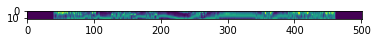

In [20]:
model.plotOriginalImage(dataset[0][0][2])

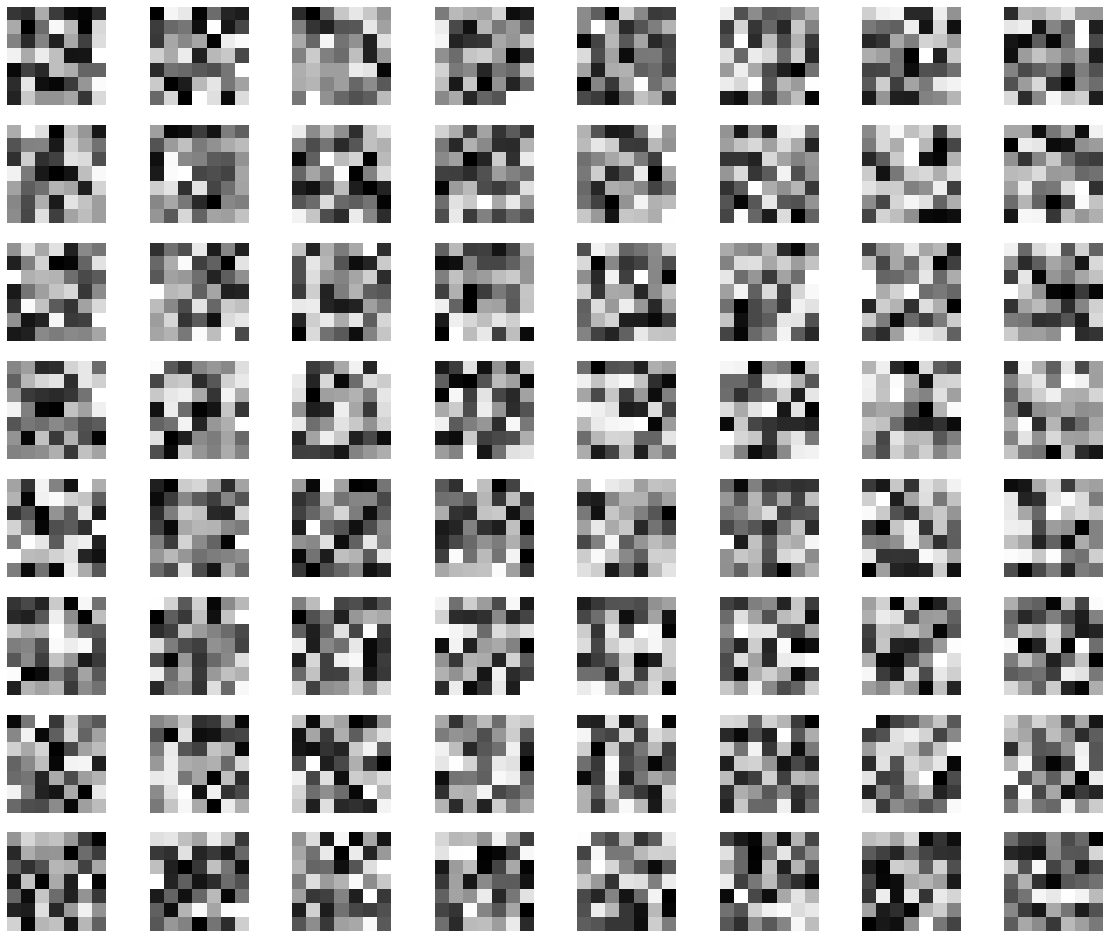

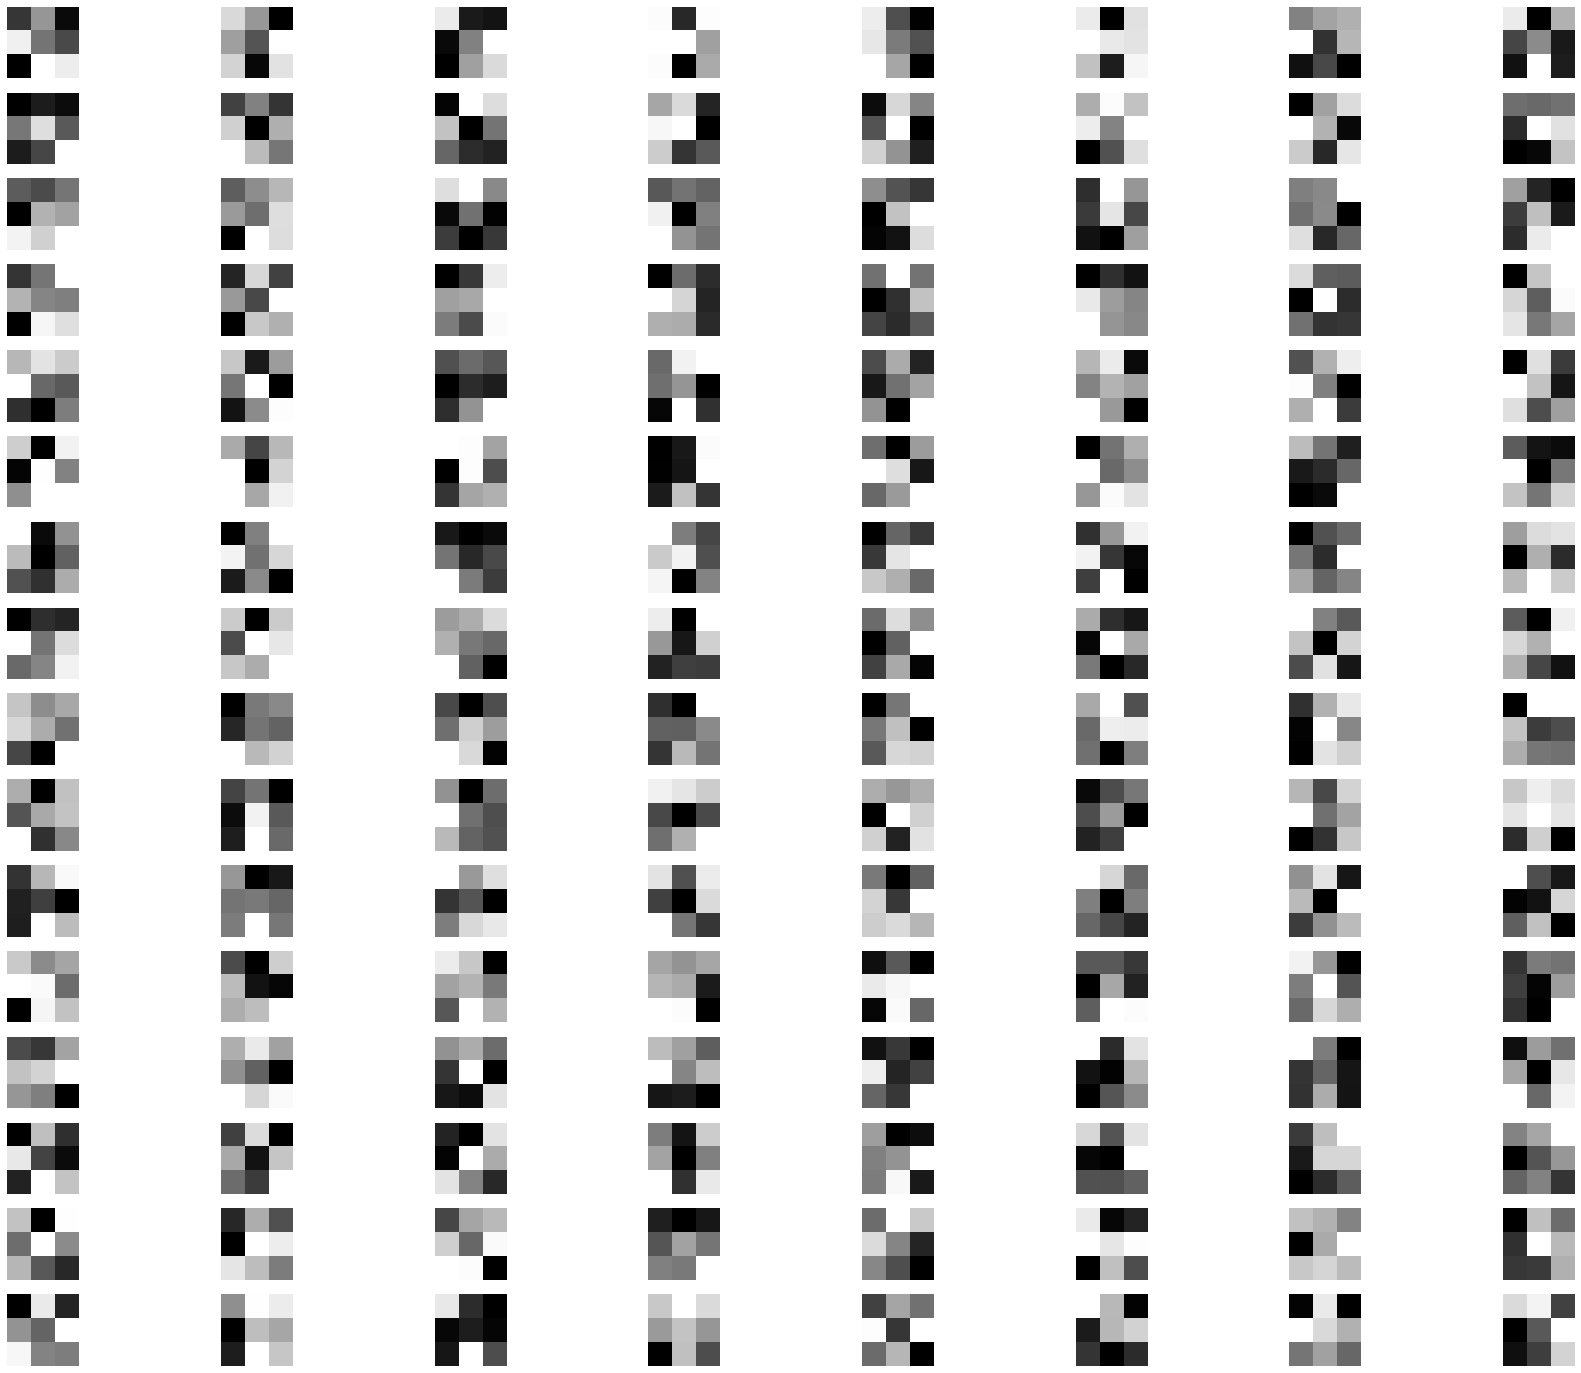

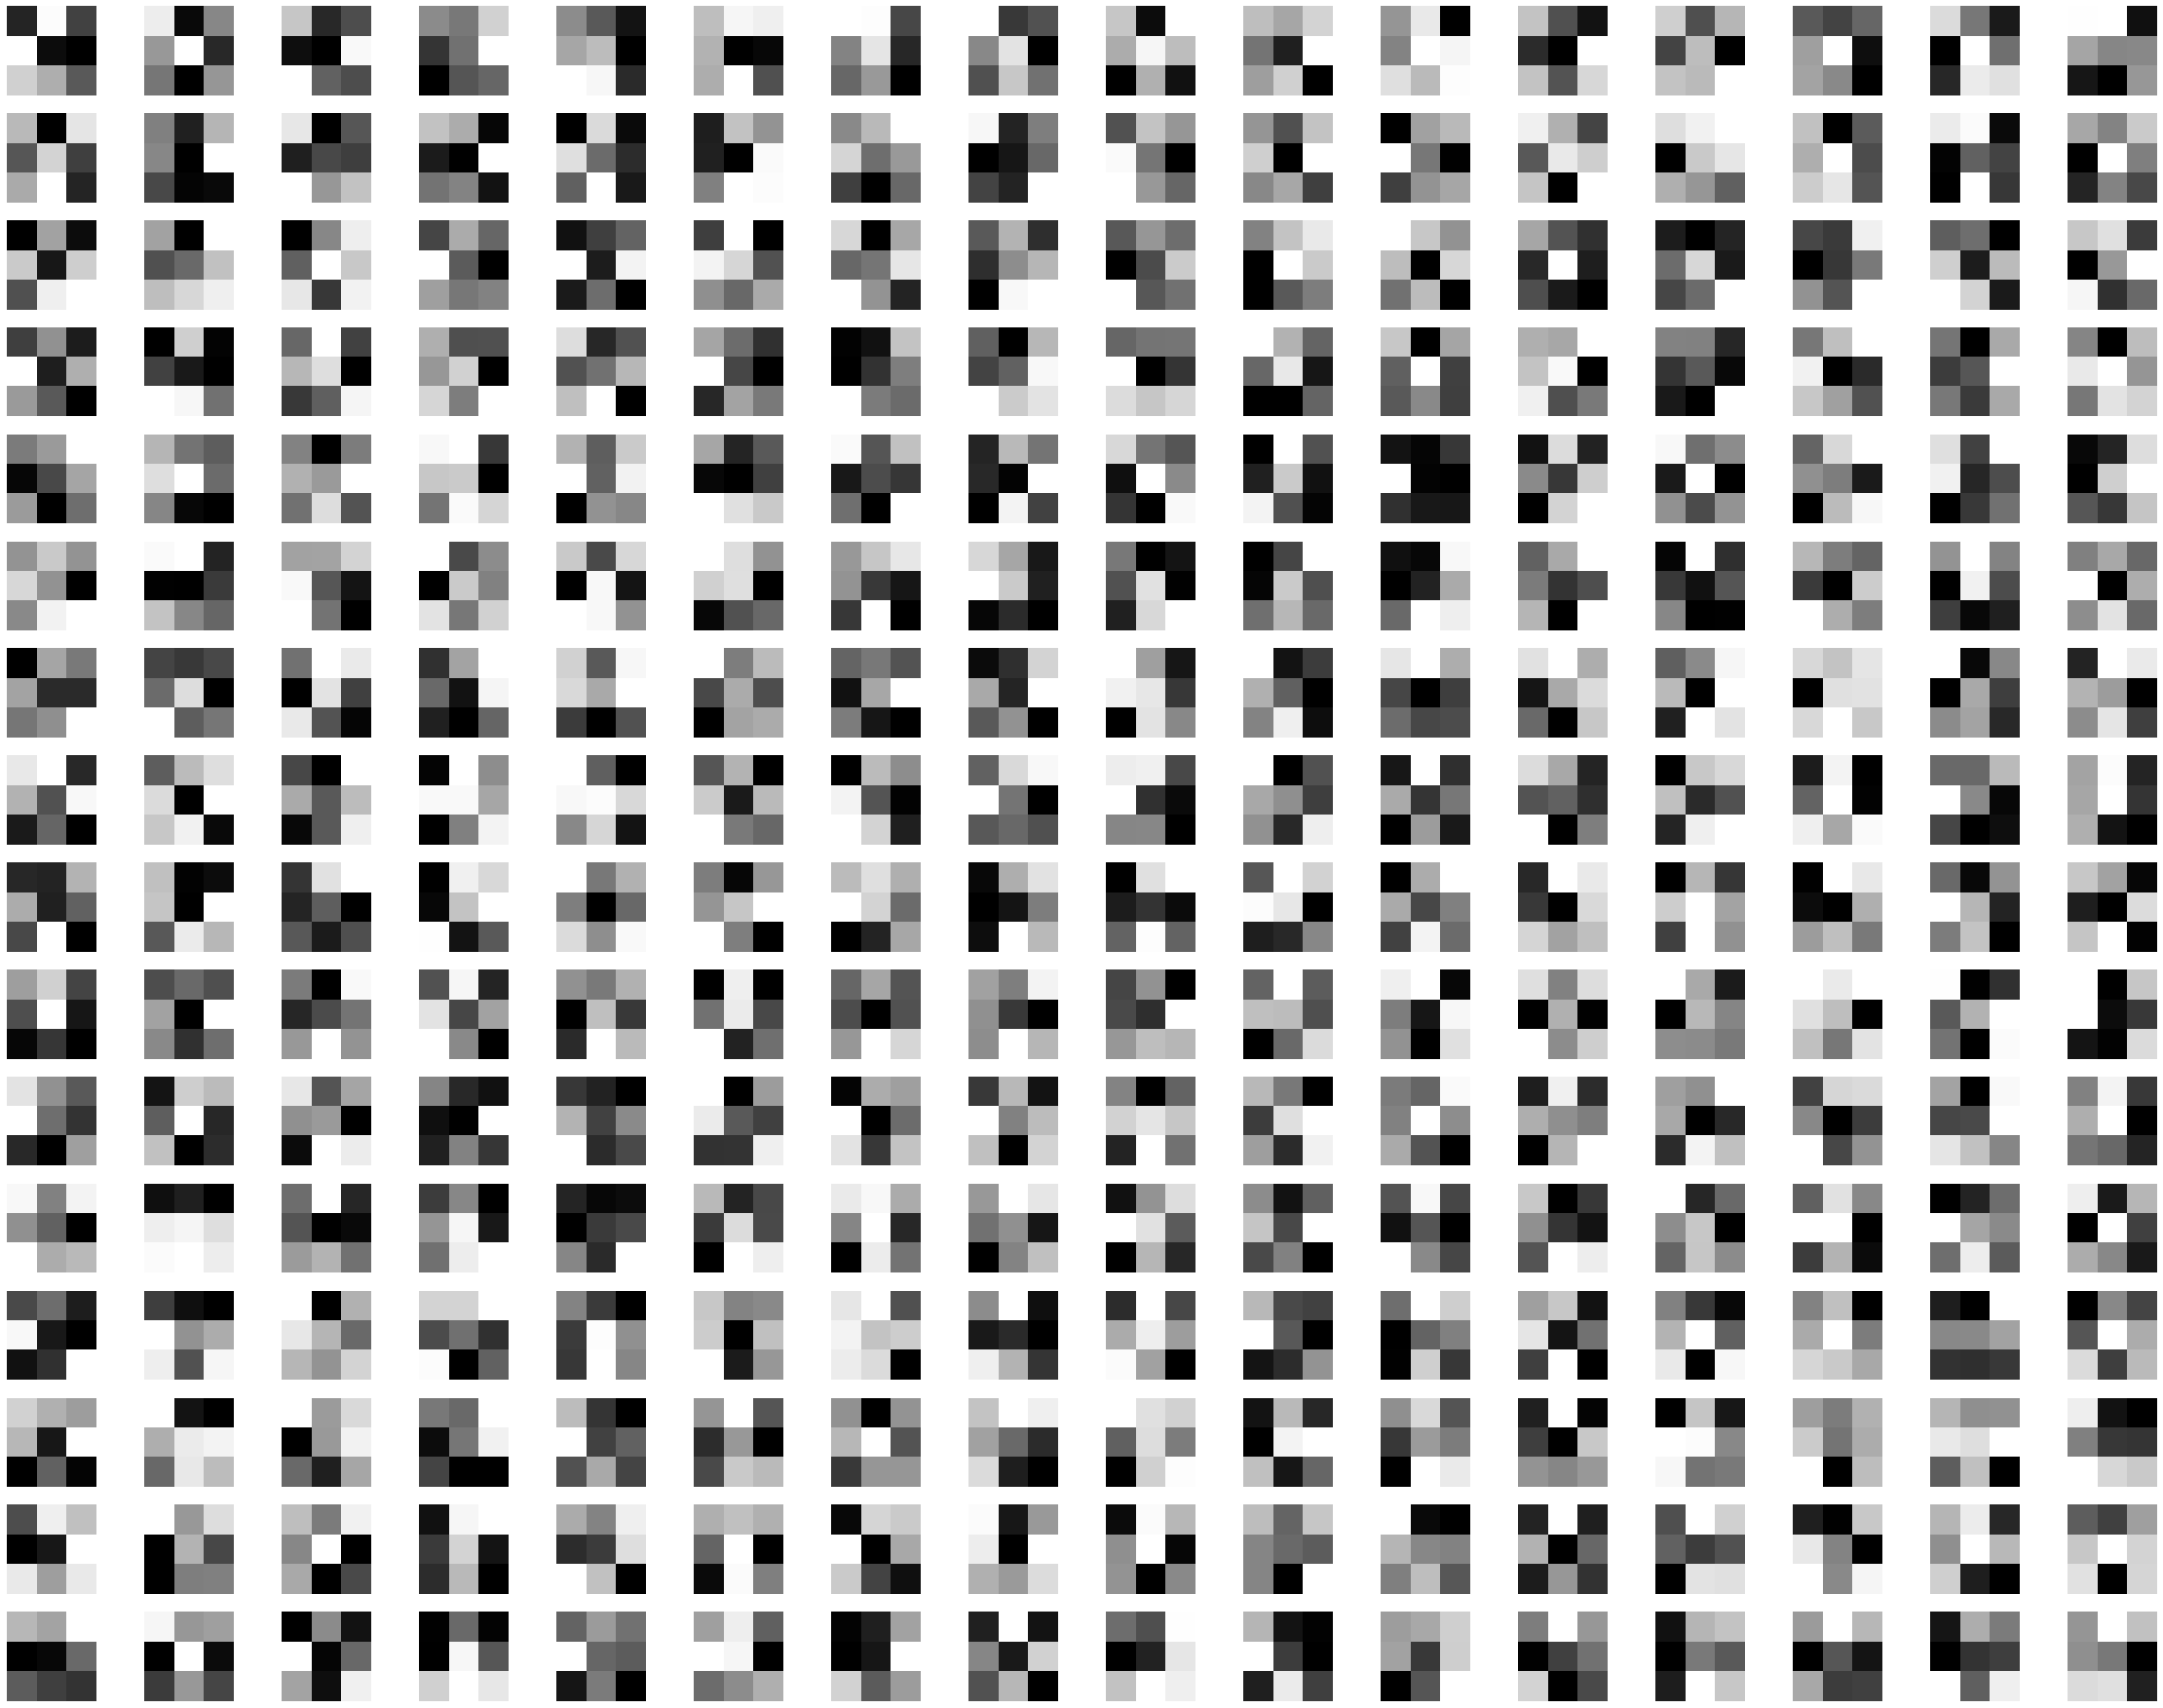

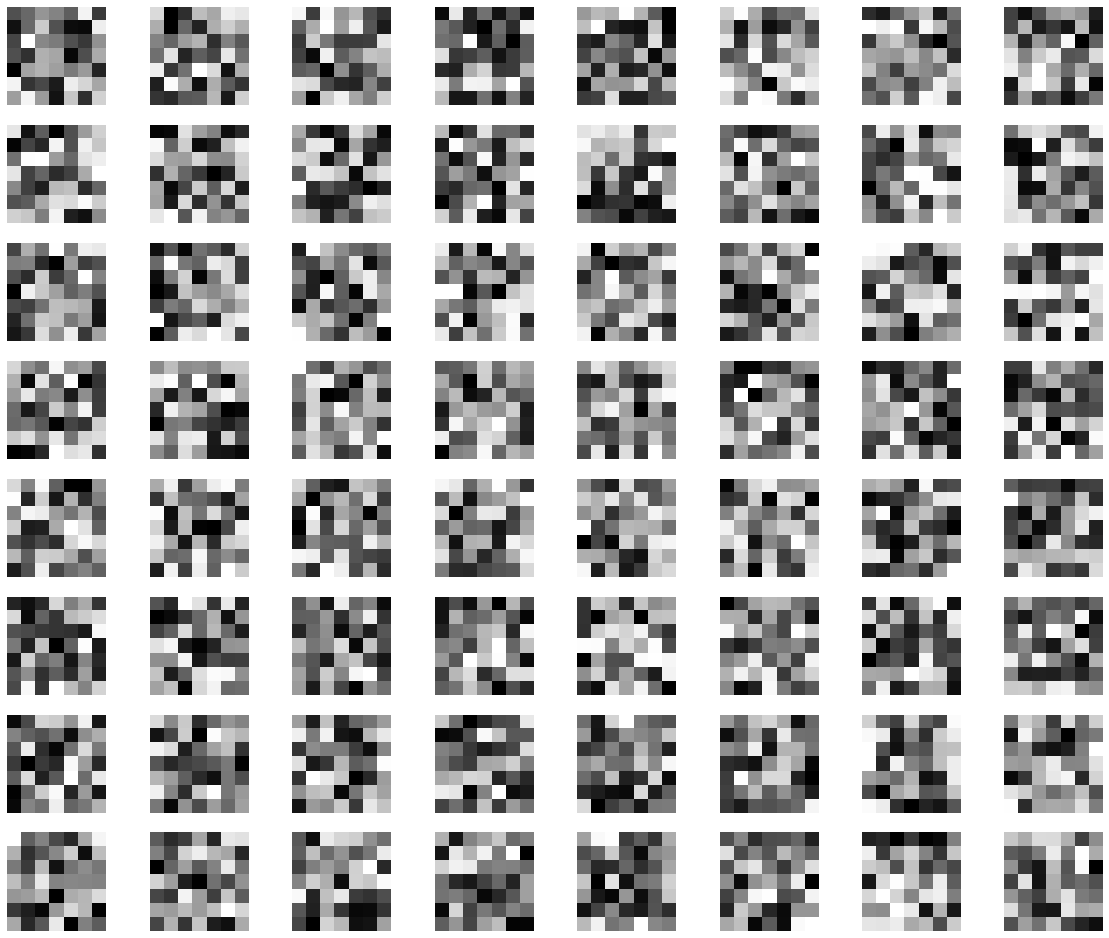

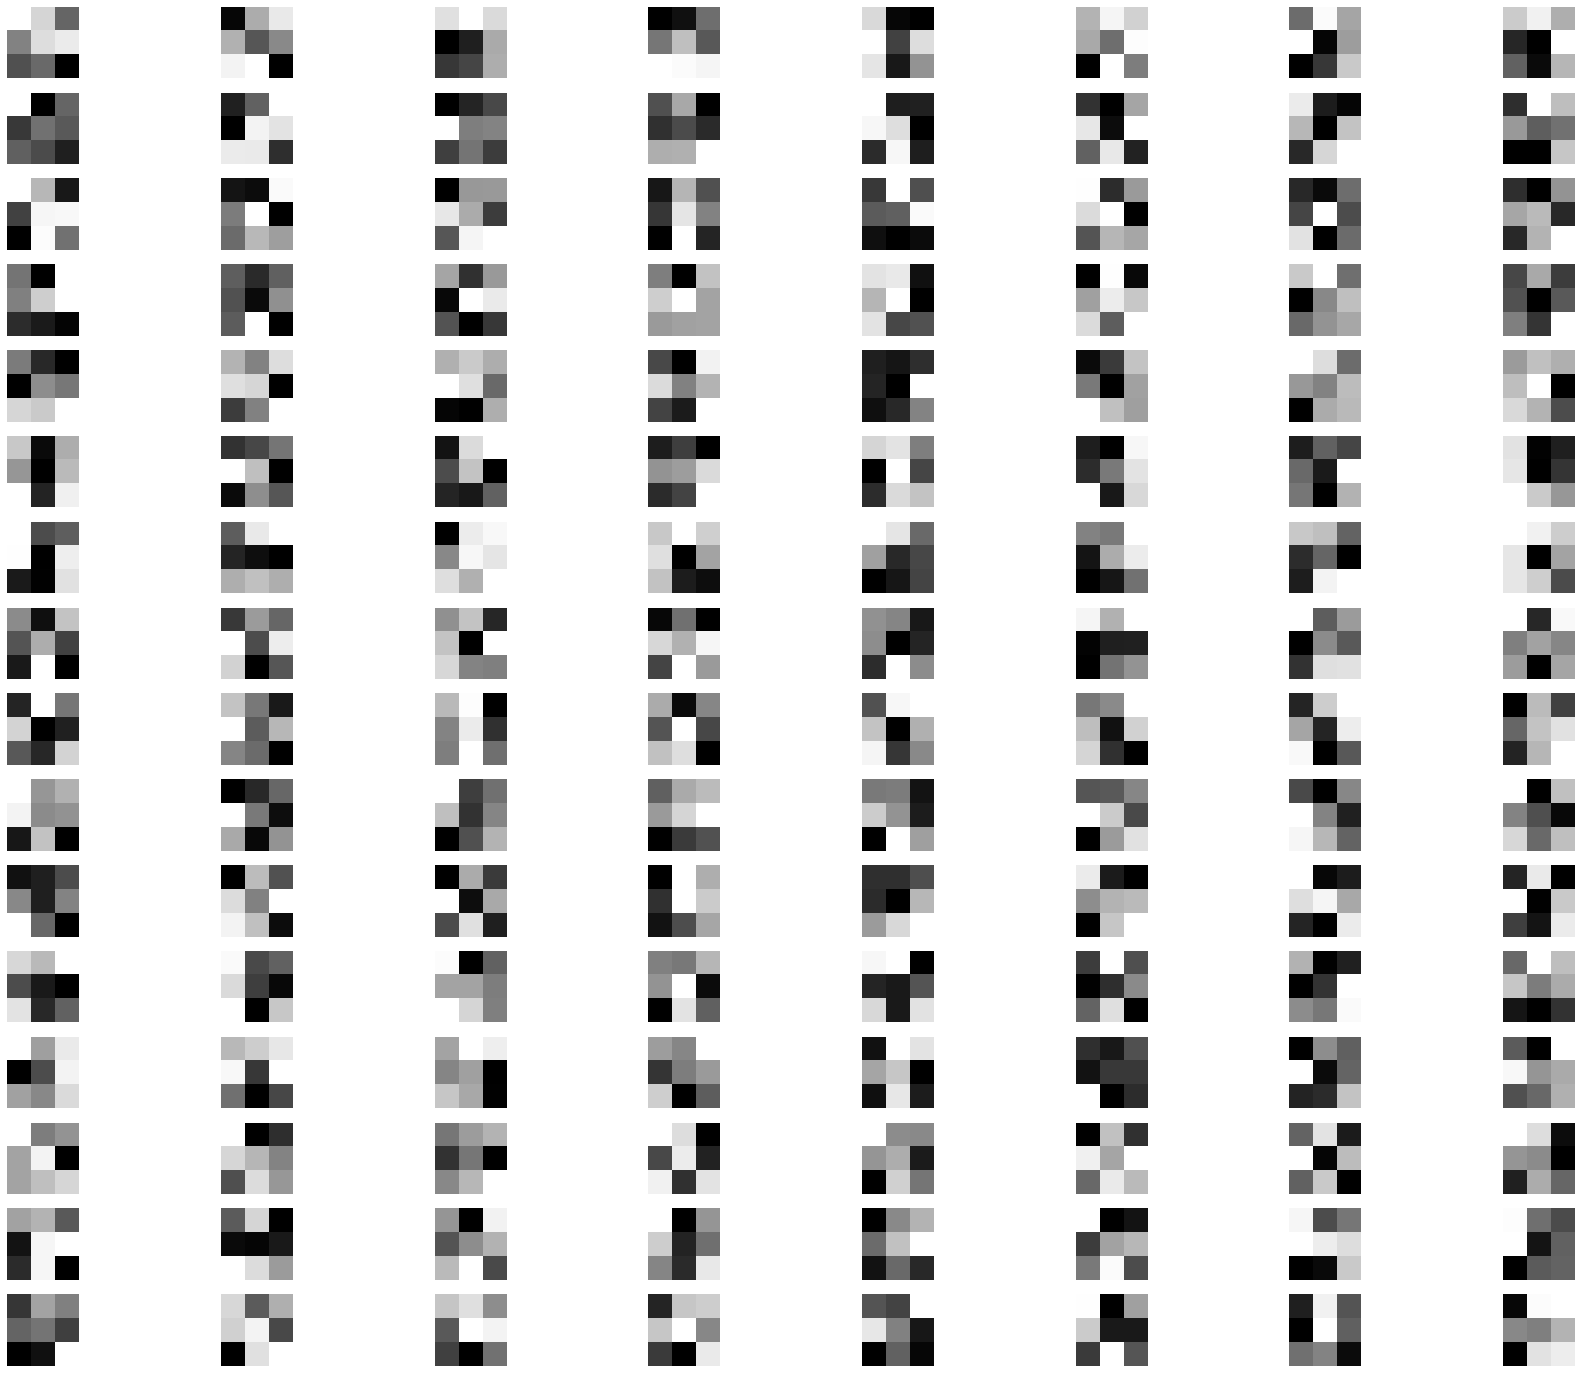

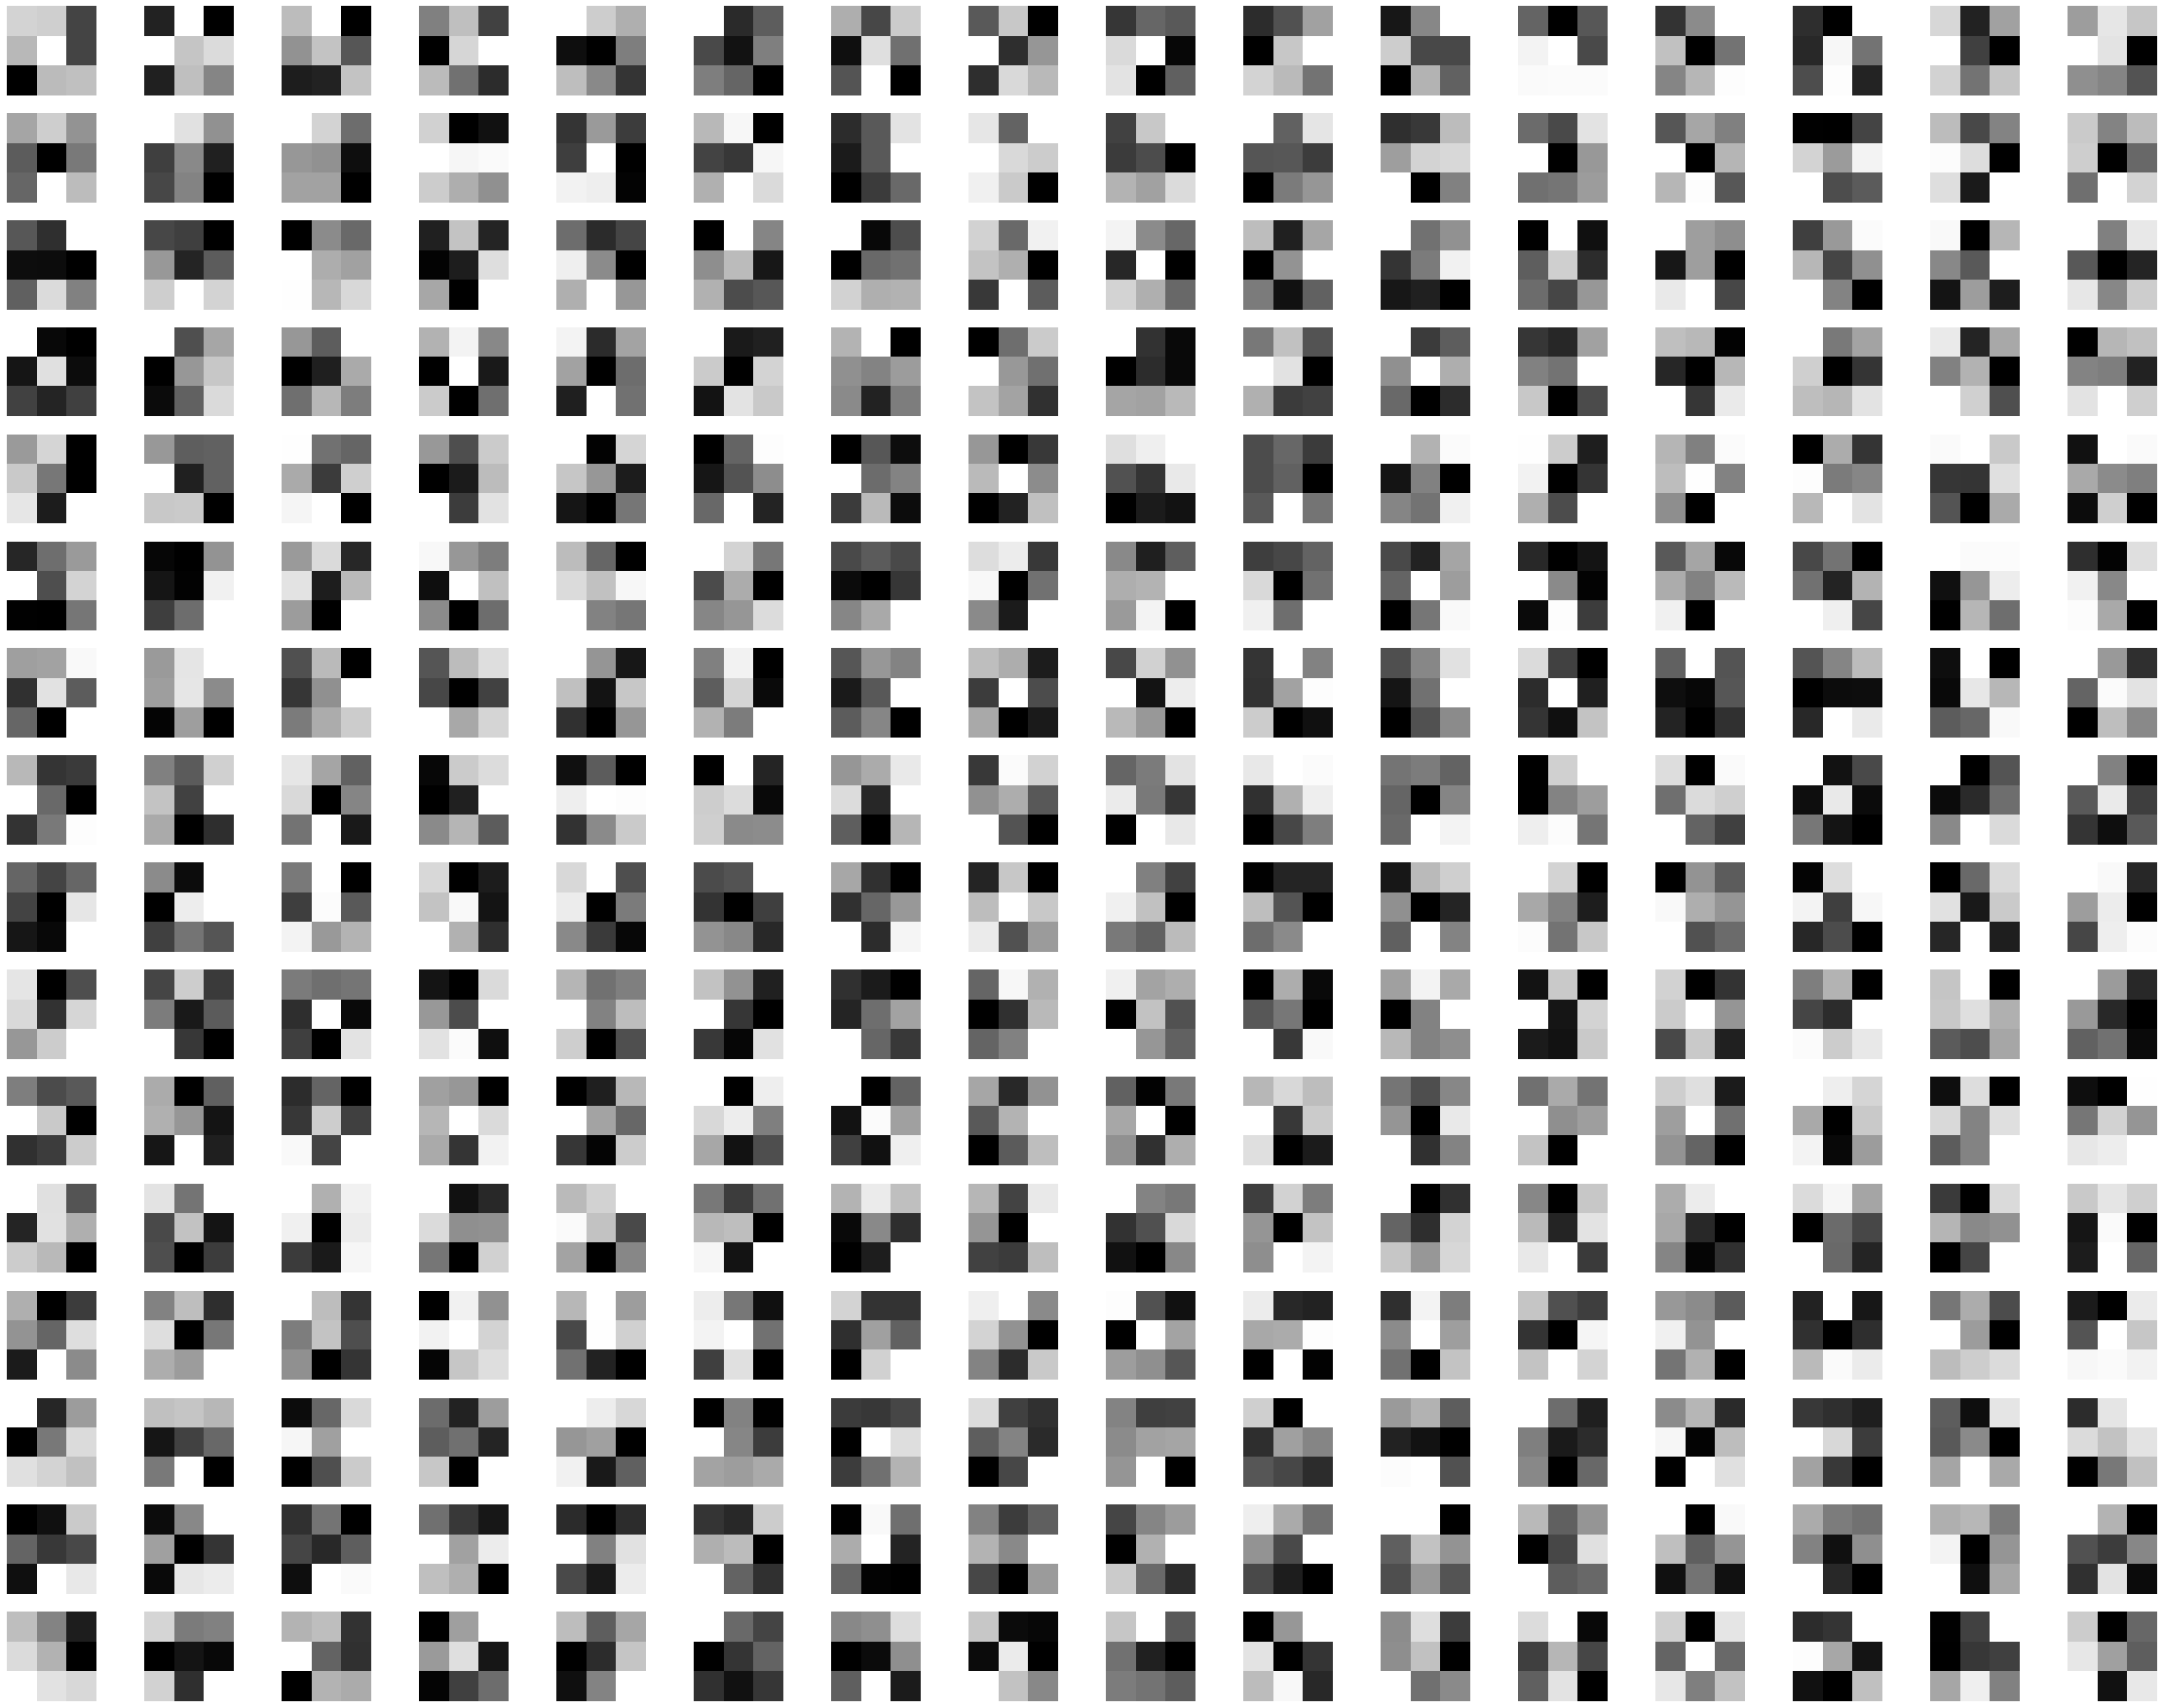

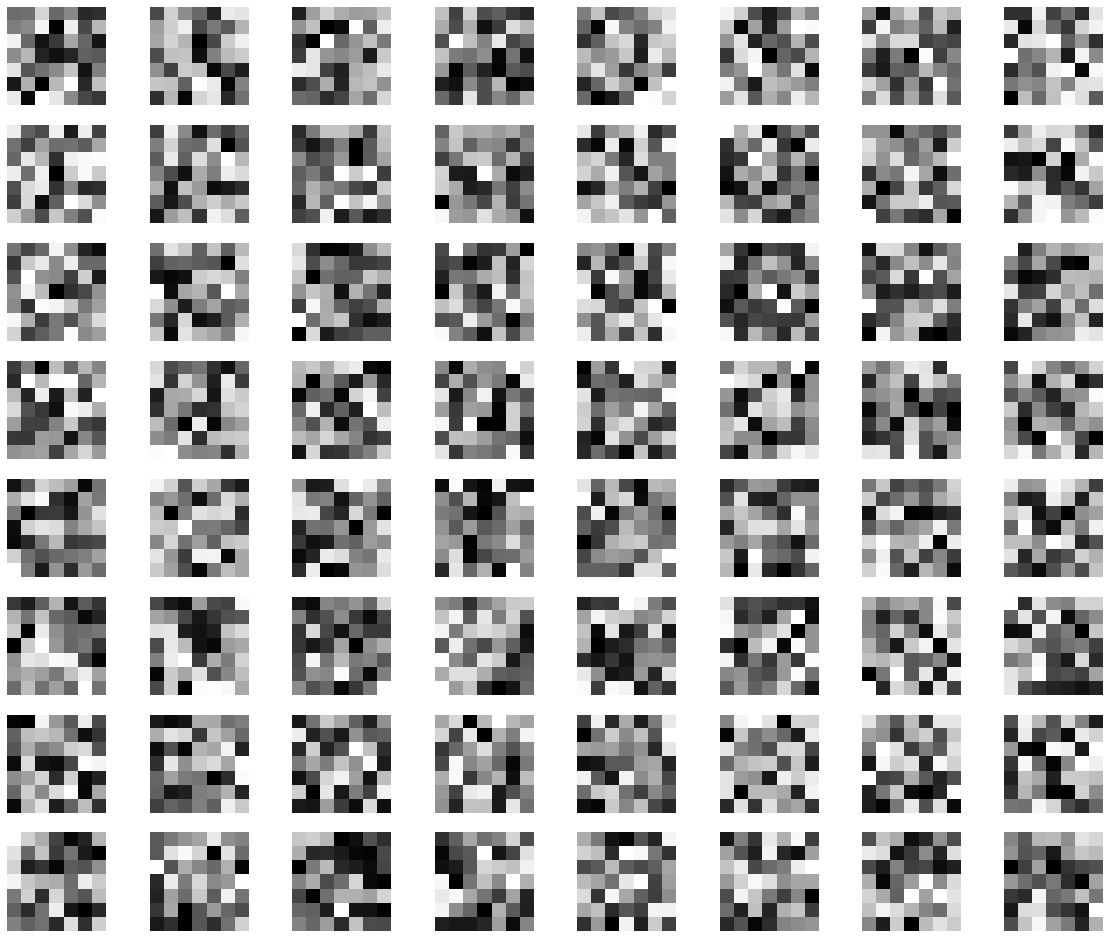

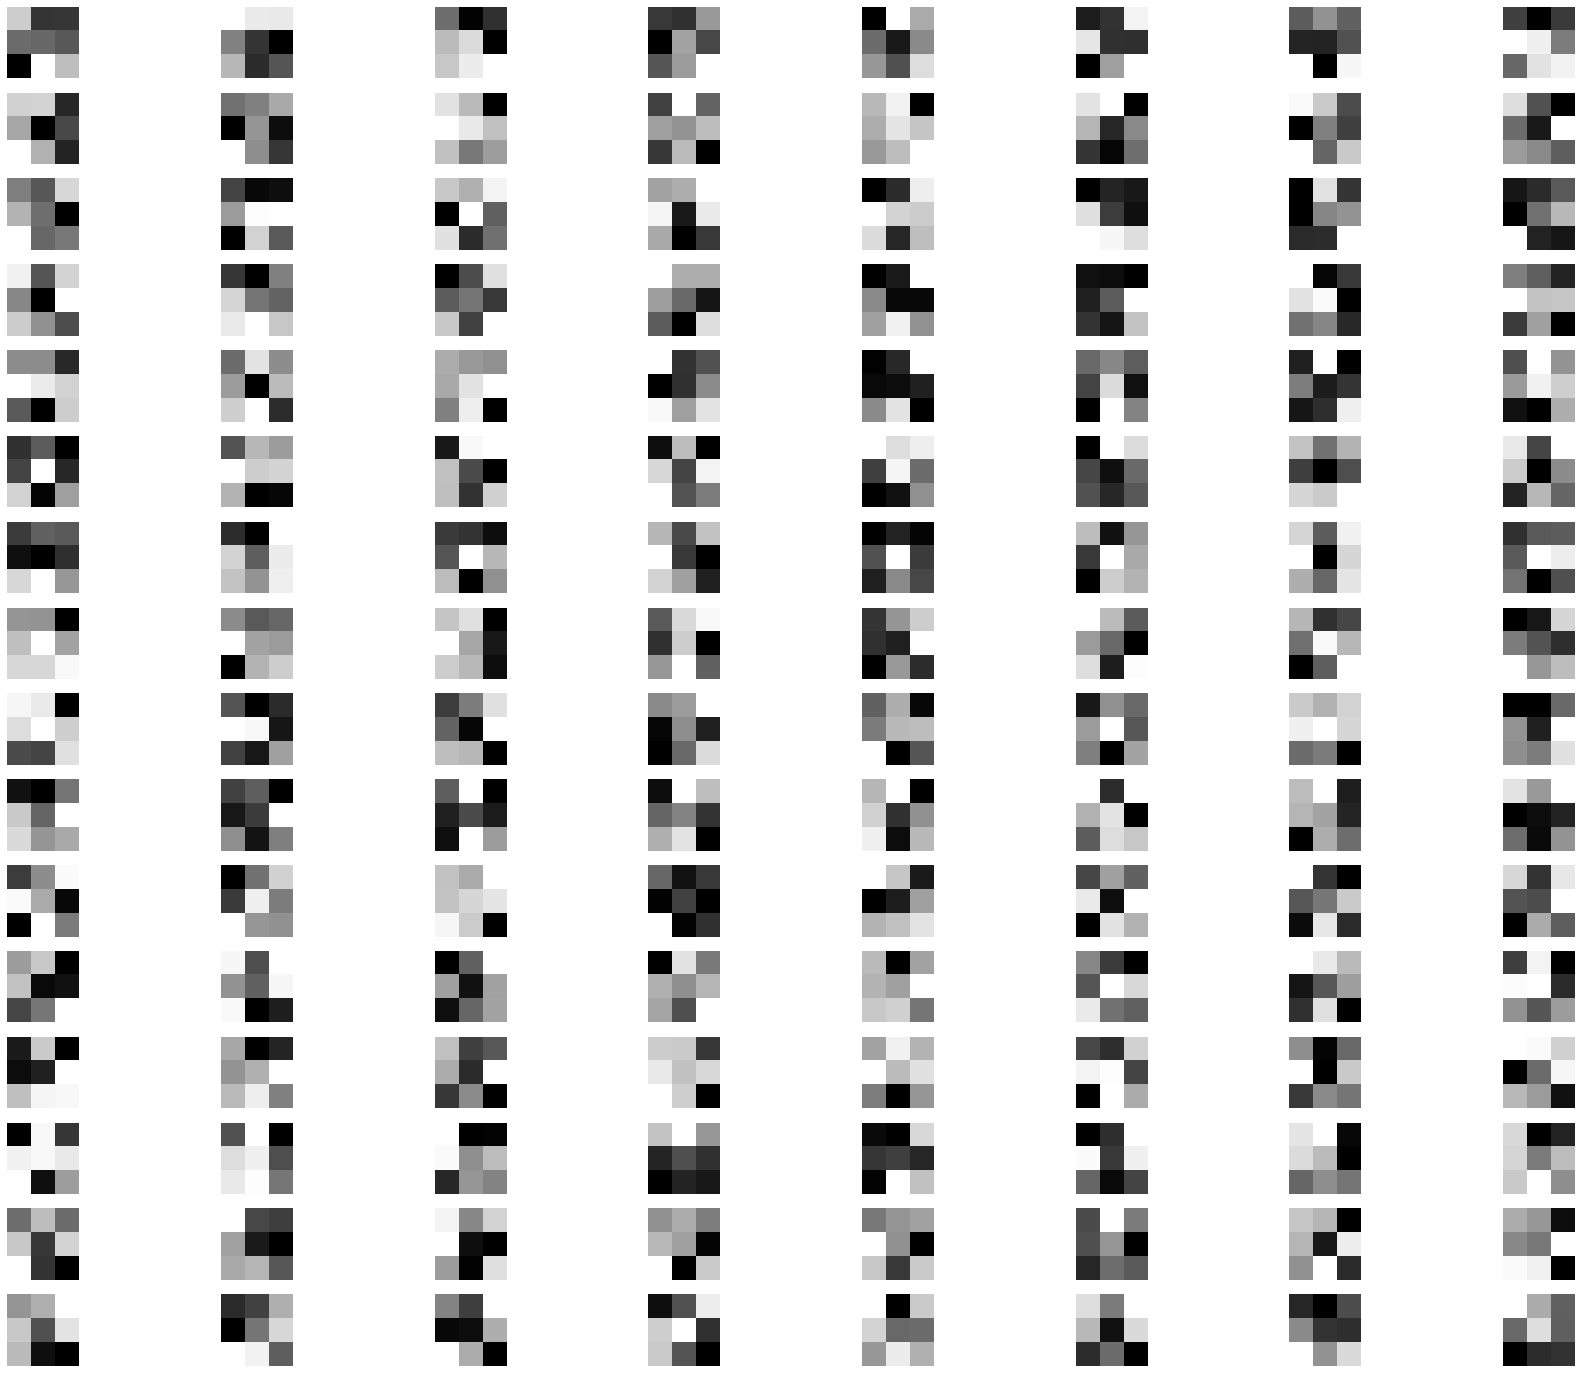

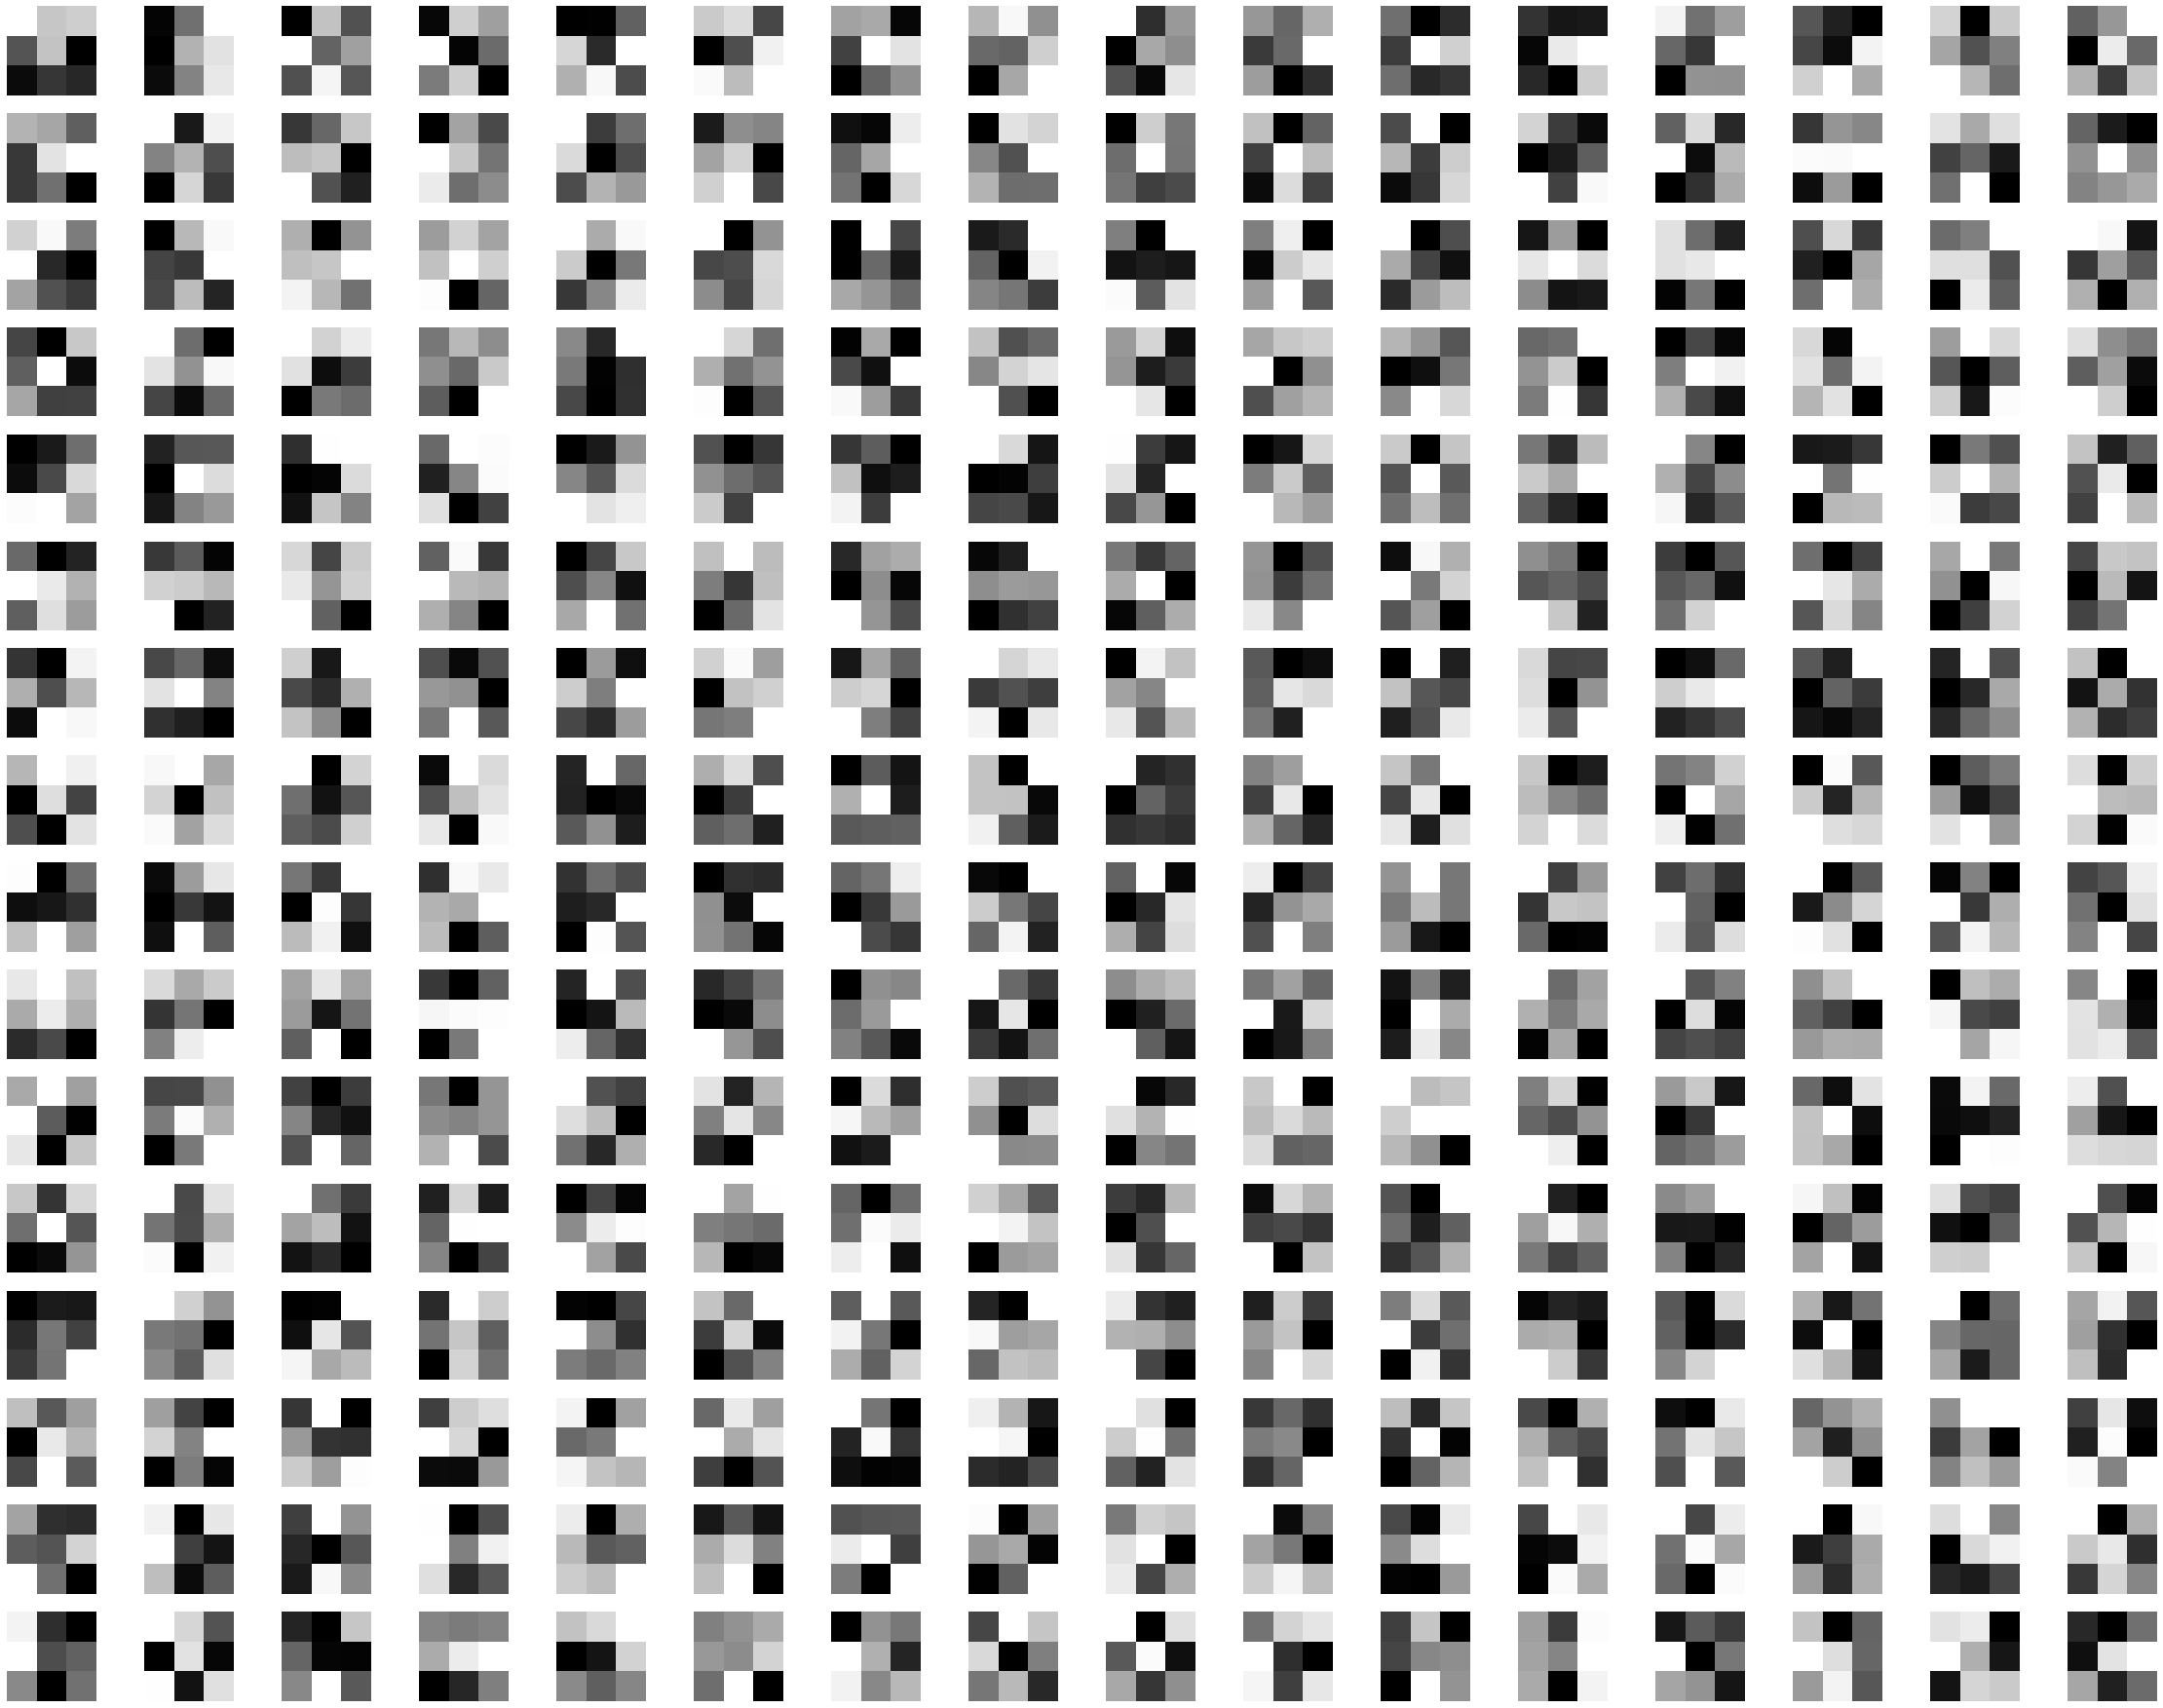

In [21]:
model.plotFilter(where='first', data_type='spec', when='before_train')
model.plotFilter(where='middle', data_type='spec', when='before_train')
model.plotFilter(where='last', data_type='spec', when='before_train')
model.plotFilter(where='first', data_type='mfcc', when='before_train')
model.plotFilter(where='middle', data_type='mfcc', when='before_train')
model.plotFilter(where='last', data_type='mfcc', when='before_train')
model.plotFilter(where='first', data_type='chroma', when='before_train')
model.plotFilter(where='middle', data_type='chroma', when='before_train')
model.plotFilter(where='last', data_type='chroma', when='before_train')

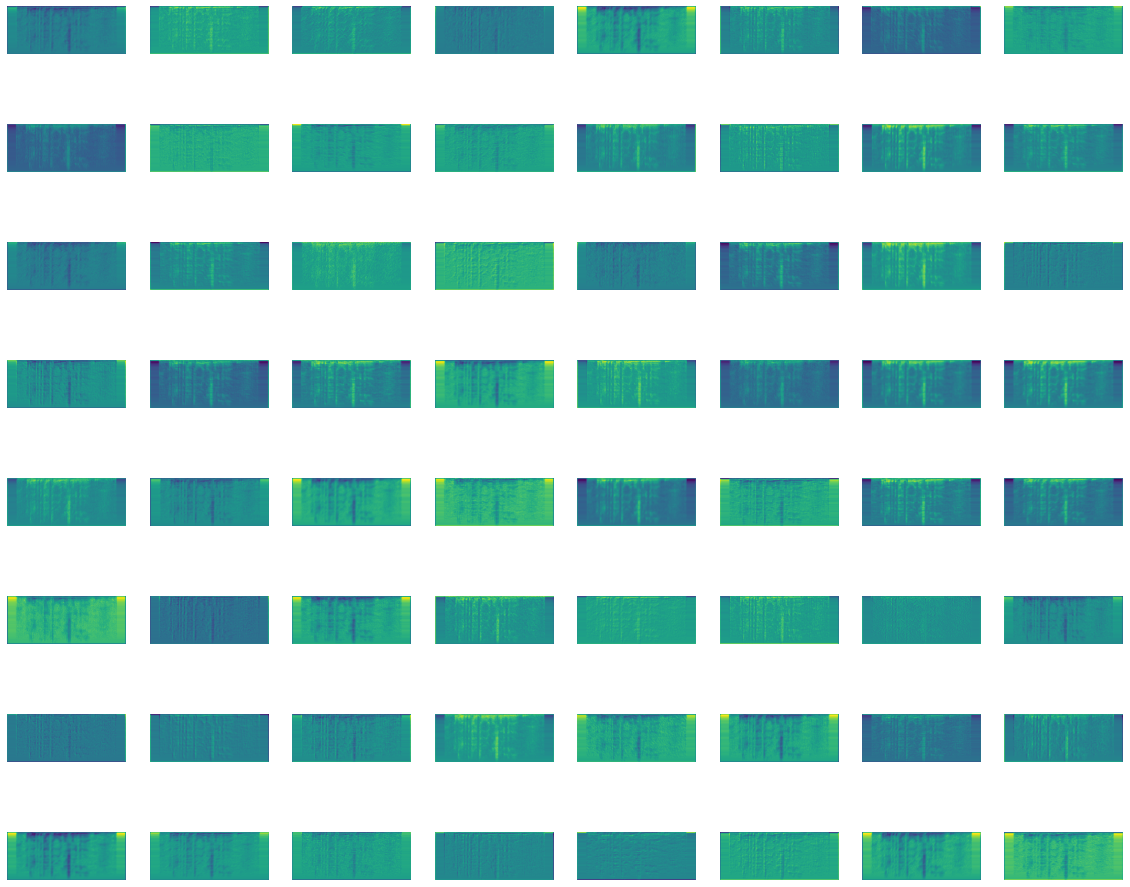

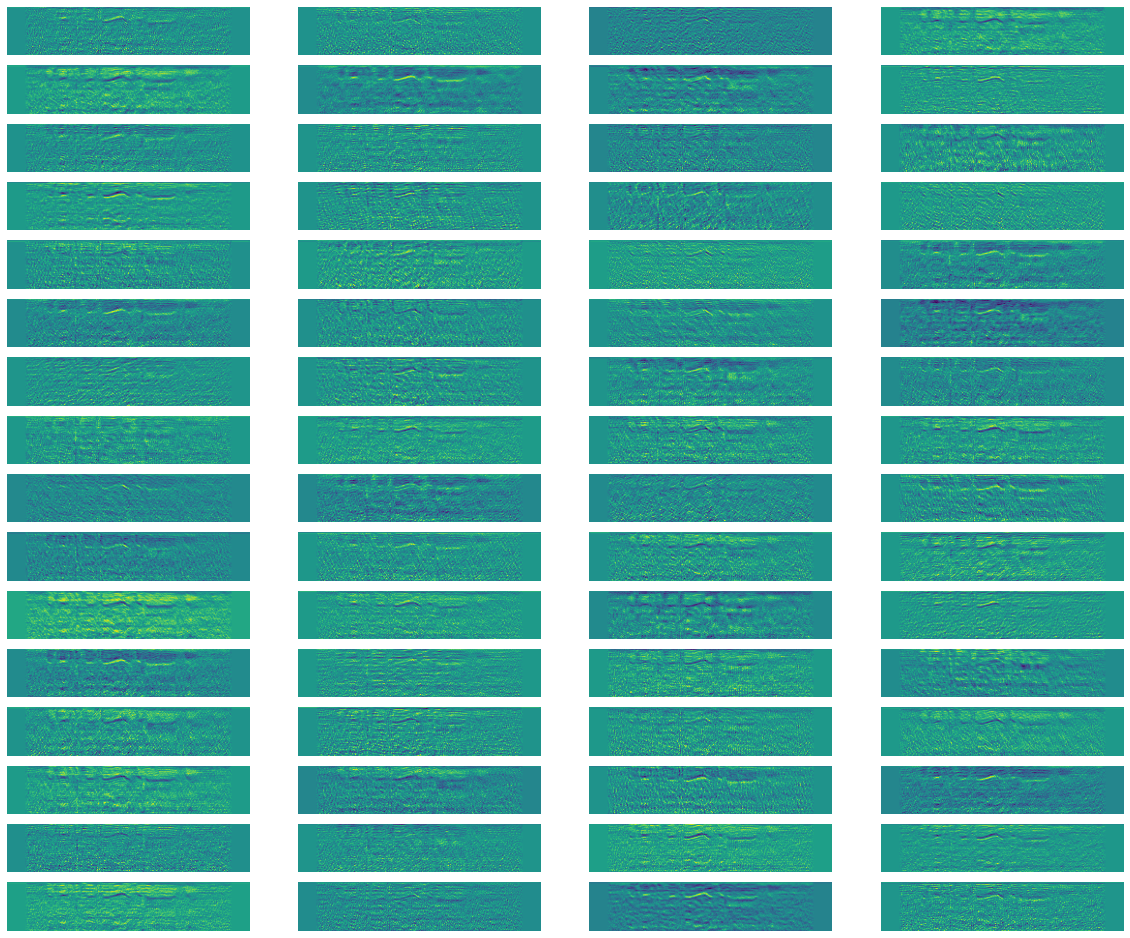

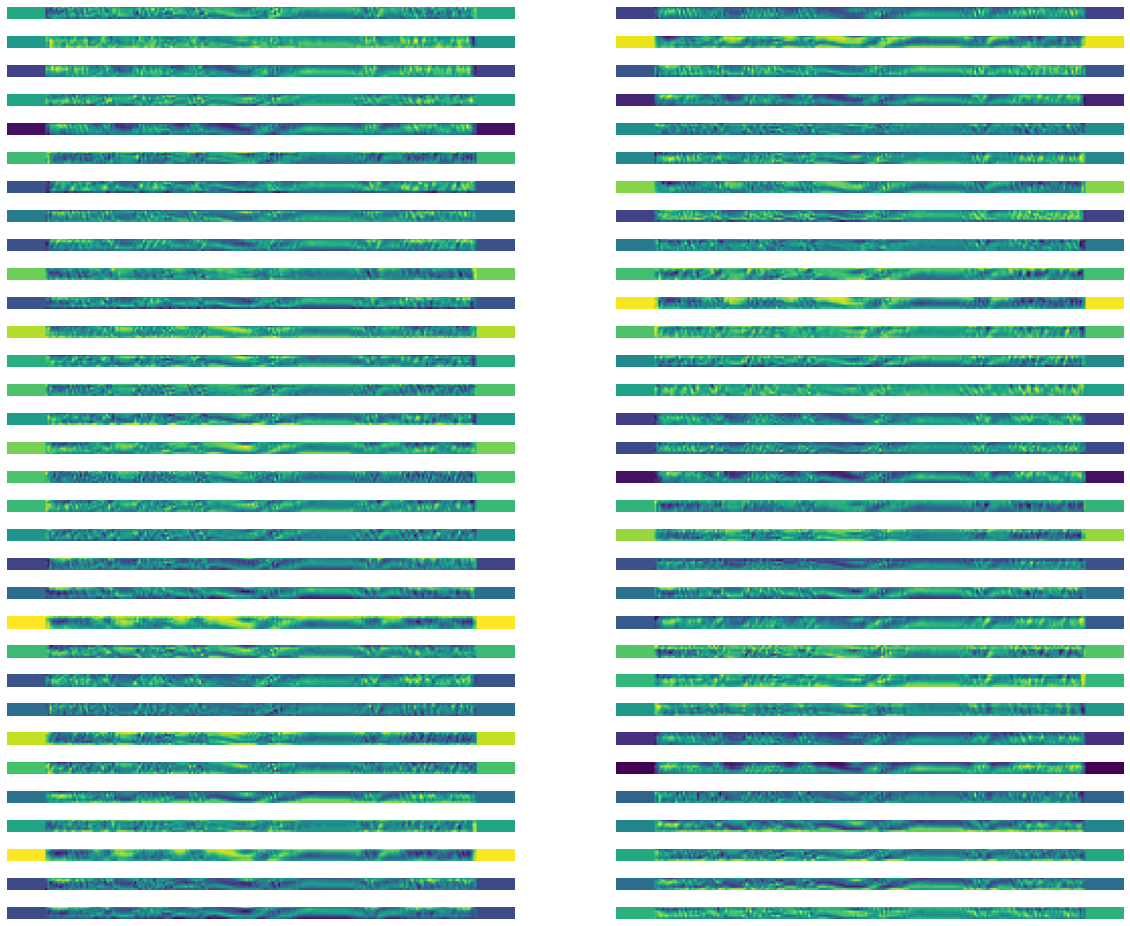

In [22]:
model.plotFeatureMap(dataset[0][0][0].to(device), data_type='spec', when='before_train')
model.plotFeatureMap(dataset[0][0][1].to(device), data_type='mfcc', when='before_train')
model.plotFeatureMap(dataset[0][0][2].to(device), data_type='chroma', when='before_train')

In [23]:
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [24]:
model.train_(train_loader, test_loader, 0.0005, 15, device)

100%|██████████| 61/61 [02:52<00:00,  2.83s/it]


epoch 1 time: 172.79561829566956sec(s).
epoch 1 train accuracy: 0.7250715959385576
epoch 1 loss: 0.6950094260153223


100%|██████████| 16/16 [00:09<00:00,  1.66it/s]


epoch 1 val accuracy: 0.19667013527575442
epoch 1 val loss: 3.6164380460977554


100%|██████████| 61/61 [02:52<00:00,  2.83s/it]


epoch 2 time: 172.81189894676208sec(s).
epoch 2 train accuracy: 0.9138245248633169
epoch 2 loss: 0.2847750975338162


100%|██████████| 16/16 [00:09<00:00,  1.66it/s]


epoch 2 val accuracy: 0.918834547346514
epoch 2 val loss: 0.2007118139299564


100%|██████████| 61/61 [02:53<00:00,  2.84s/it]


epoch 3 time: 173.14115500450134sec(s).
epoch 3 train accuracy: 0.9271023171049206
epoch 3 loss: 0.20772920292420466


100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


epoch 3 val accuracy: 0.21852237252861603
epoch 3 val loss: 13.429416120052338


100%|██████████| 61/61 [02:52<00:00,  2.83s/it]


epoch 4 time: 172.69223761558533sec(s).
epoch 4 train accuracy: 0.9325696433220515
epoch 4 loss: 0.22361968671444987


100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


epoch 4 val accuracy: 0.4505723204994797
epoch 4 val loss: 7.18692974280566


100%|██████████| 61/61 [02:53<00:00,  2.84s/it]


epoch 5 time: 173.32461857795715sec(s).
epoch 5 train accuracy: 0.9031502212965373
epoch 5 loss: 0.3204734452435228


100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


epoch 5 val accuracy: 0.6045785639958376
epoch 5 val loss: 2.4708521366119385


100%|██████████| 61/61 [02:52<00:00,  2.83s/it]


epoch 6 time: 172.66741371154785sec(s).
epoch 6 train accuracy: 0.9552199947930227
epoch 6 loss: 0.16074289131115693


100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


epoch 6 val accuracy: 0.7481789802289281
epoch 6 val loss: 1.4134090877778362


100%|██████████| 61/61 [02:53<00:00,  2.84s/it]


epoch 7 time: 173.5388741493225sec(s).
epoch 7 train accuracy: 0.9703202291070033
epoch 7 loss: 0.14715442959158148


100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


epoch 7 val accuracy: 0.9583766909469302
epoch 7 val loss: 0.11655129311111523


100%|██████████| 61/61 [02:52<00:00,  2.83s/it]


epoch 8 time: 172.9360272884369sec(s).
epoch 8 train accuracy: 0.9695391825045561
epoch 8 loss: 0.10419993502561187


100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


epoch 8 val accuracy: 0.9719042663891779
epoch 8 val loss: 0.07552192141884007


100%|██████████| 61/61 [02:53<00:00,  2.85s/it]


epoch 9 time: 173.711505651474sec(s).
epoch 9 train accuracy: 0.9721426711793804
epoch 9 loss: 0.1469482262542502


100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


epoch 9 val accuracy: 0.7783558792924038
epoch 9 val loss: 0.7633757721632719


100%|██████████| 61/61 [02:52<00:00,  2.83s/it]


epoch 10 time: 172.85764241218567sec(s).
epoch 10 train accuracy: 0.9651132517573549
epoch 10 loss: 0.10947108009188879


100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


epoch 10 val accuracy: 0.8803329864724245
epoch 10 val loss: 0.3063970091752708


100%|██████████| 61/61 [02:53<00:00,  2.84s/it]


epoch 11 time: 173.36826300621033sec(s).
epoch 11 train accuracy: 0.9875032543608435
epoch 11 loss: 0.050792218147792285


100%|██████████| 16/16 [00:09<00:00,  1.66it/s]


epoch 11 val accuracy: 0.7429760665972945
epoch 11 val loss: 1.3761072662509832


100%|██████████| 61/61 [02:52<00:00,  2.83s/it]


epoch 12 time: 172.7215917110443sec(s).
epoch 12 train accuracy: 0.9747461598542047
epoch 12 loss: 0.18440259903760964


100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


epoch 12 val accuracy: 0.9667013527575442
epoch 12 val loss: 0.10356496562505413


100%|██████████| 61/61 [02:53<00:00,  2.84s/it]


epoch 13 time: 173.18345546722412sec(s).
epoch 13 train accuracy: 0.9731840666493101
epoch 13 loss: 0.08076717536591116


100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


epoch 13 val accuracy: 0.9448491155046826
epoch 13 val loss: 0.16134026553480751


100%|██████████| 61/61 [02:52<00:00,  2.83s/it]


epoch 14 time: 172.51932835578918sec(s).
epoch 14 train accuracy: 0.9921895339755272
epoch 14 loss: 0.09397181851663397


100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


epoch 14 val accuracy: 0.5306971904266389
epoch 14 val loss: 4.771057769656181


100%|██████████| 61/61 [02:53<00:00,  2.84s/it]


epoch 15 time: 173.30891180038452sec(s).
epoch 15 train accuracy: 0.9658942983598021
epoch 15 loss: 0.10832235977420064


100%|██████████| 16/16 [00:09<00:00,  1.67it/s]

epoch 15 val accuracy: 0.9427679500520292
epoch 15 val loss: 0.2179769086651504
Finish!


(0.9719042663891779, 8)

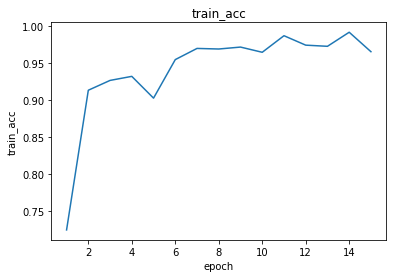

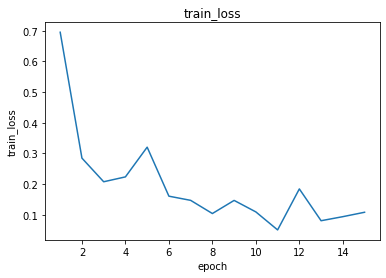

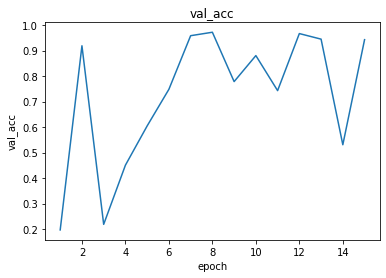

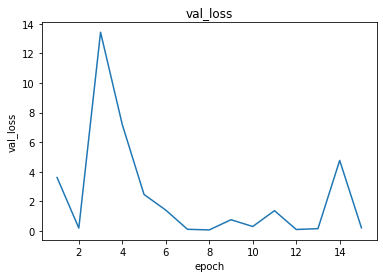

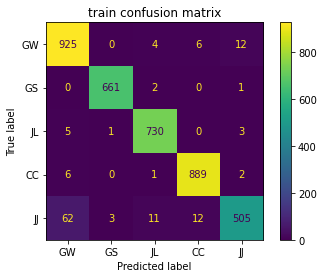

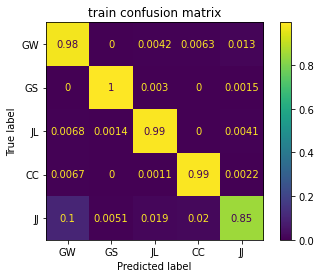

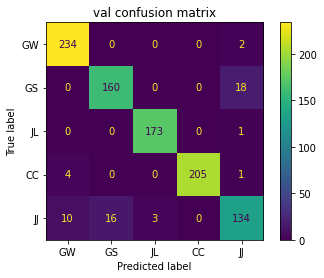

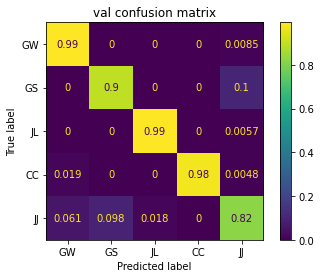

In [25]:
model.plot('train_acc')
model.plot('train_loss')
model.plot('val_acc')
model.plot('val_loss')
model.plot('confusion_train')
model.plot('confusion_normalize_train')
model.plot('confusion_val')
model.plot('confusion_normalize_val')

In [26]:
spec_weights, spec_layers, mfcc_weights, mfcc_layers, chroma_weights, chroma_layers = model.extractConvLayer()

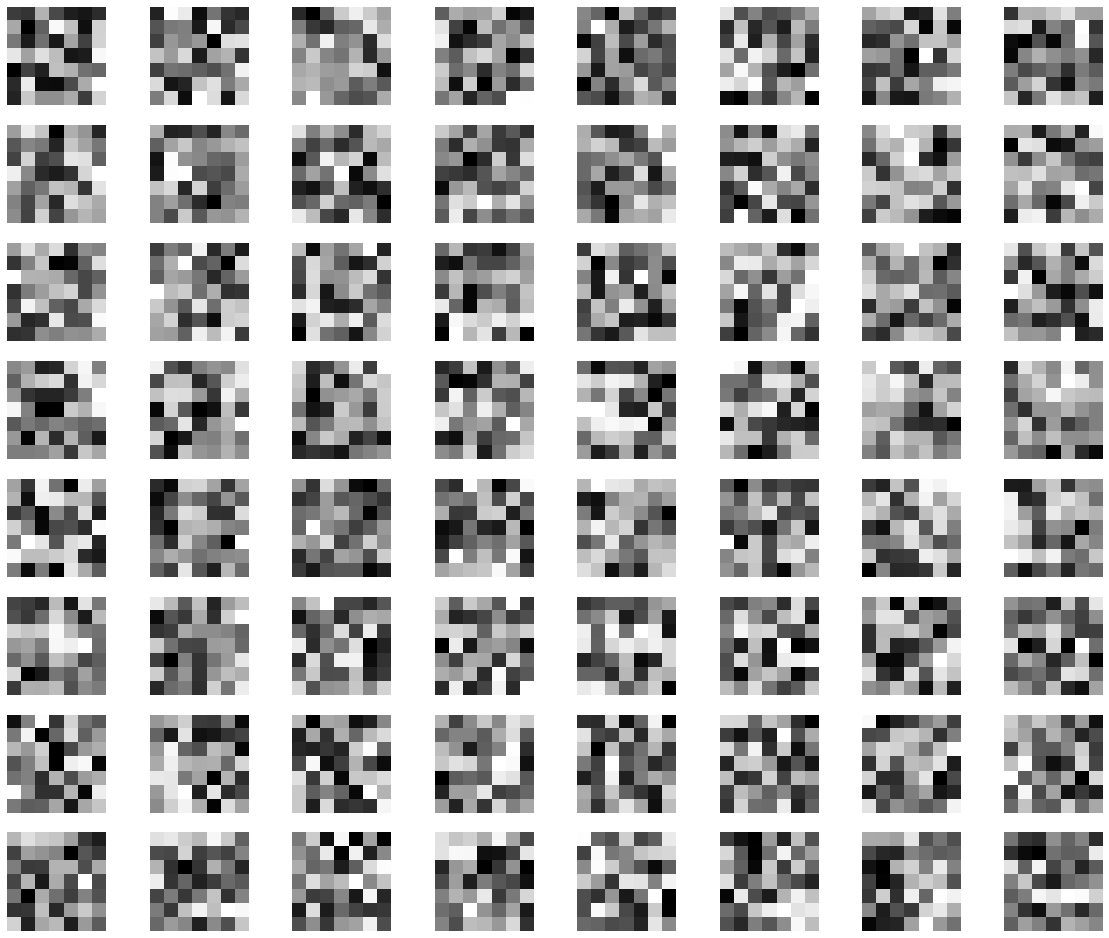

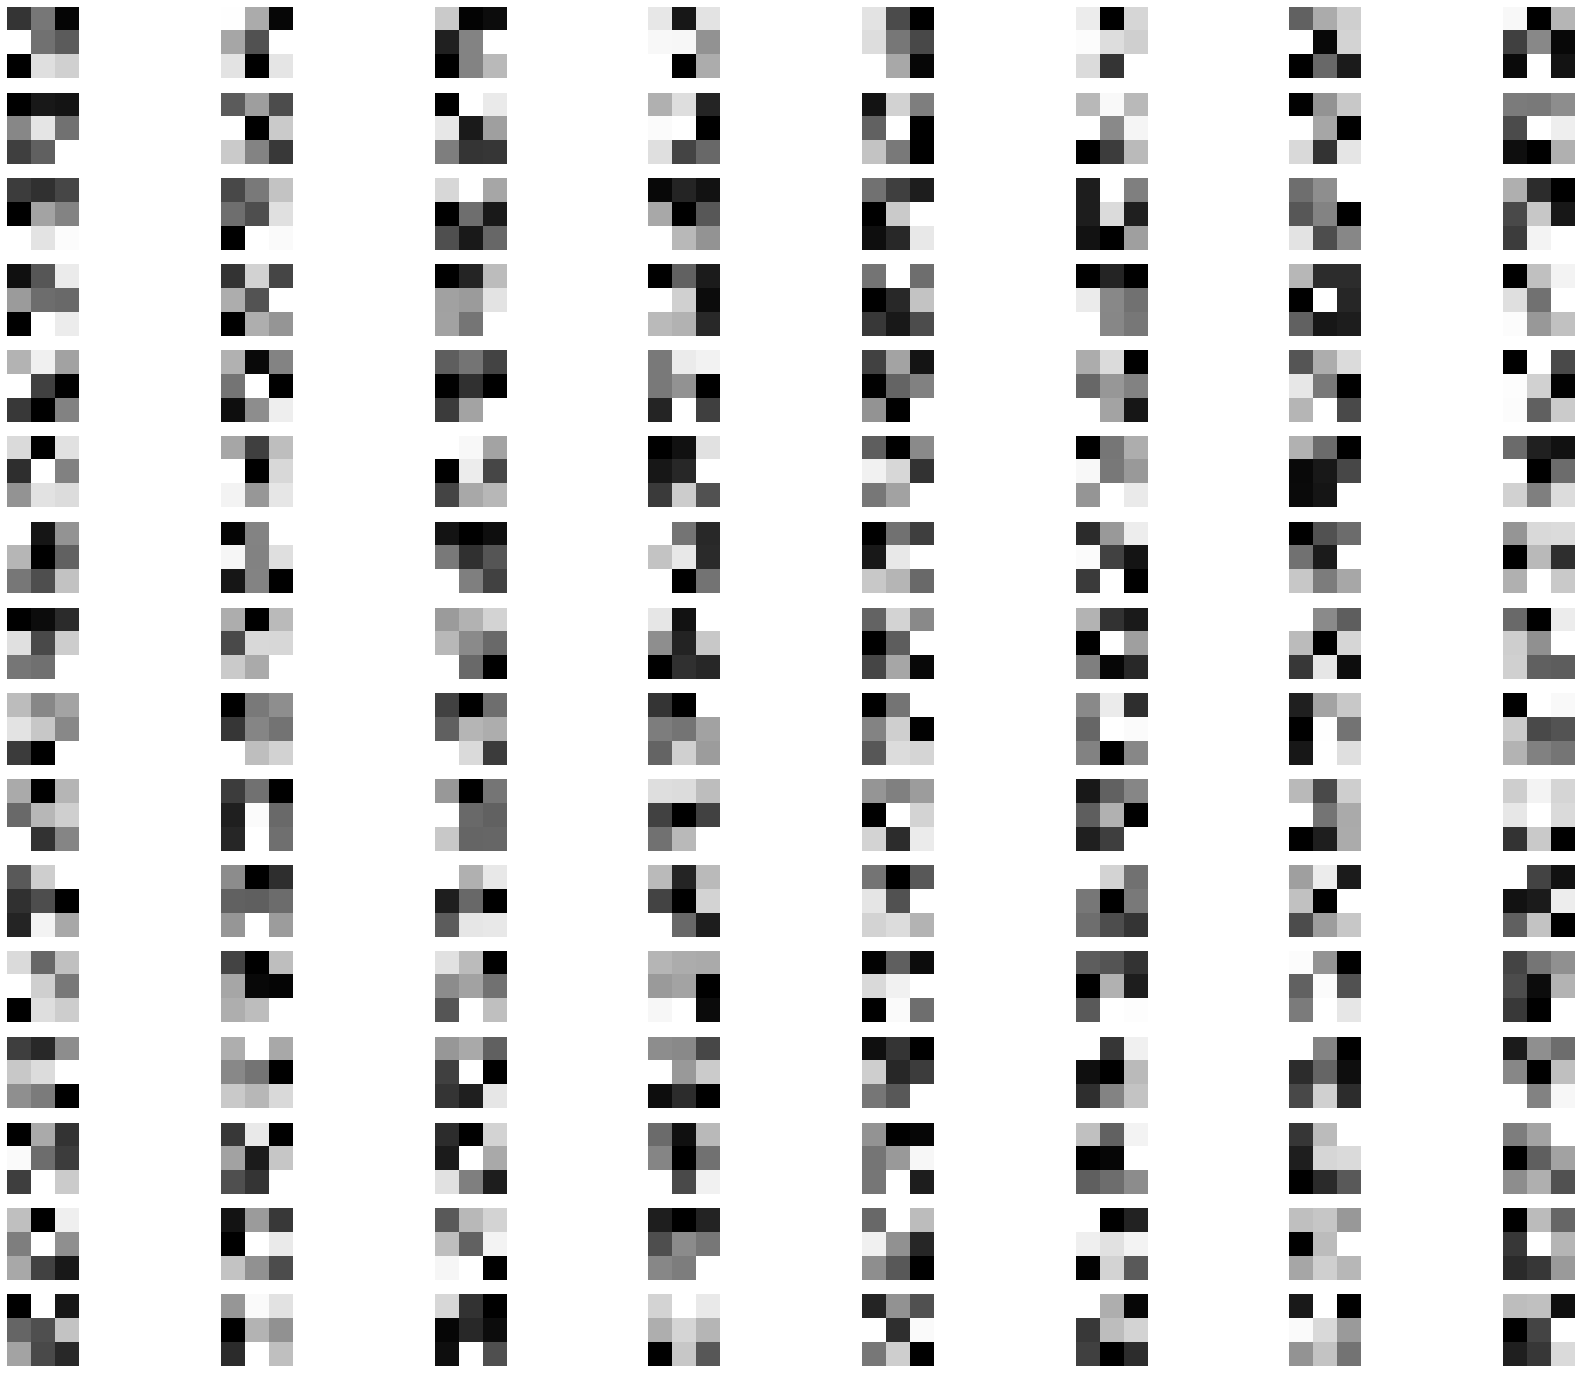

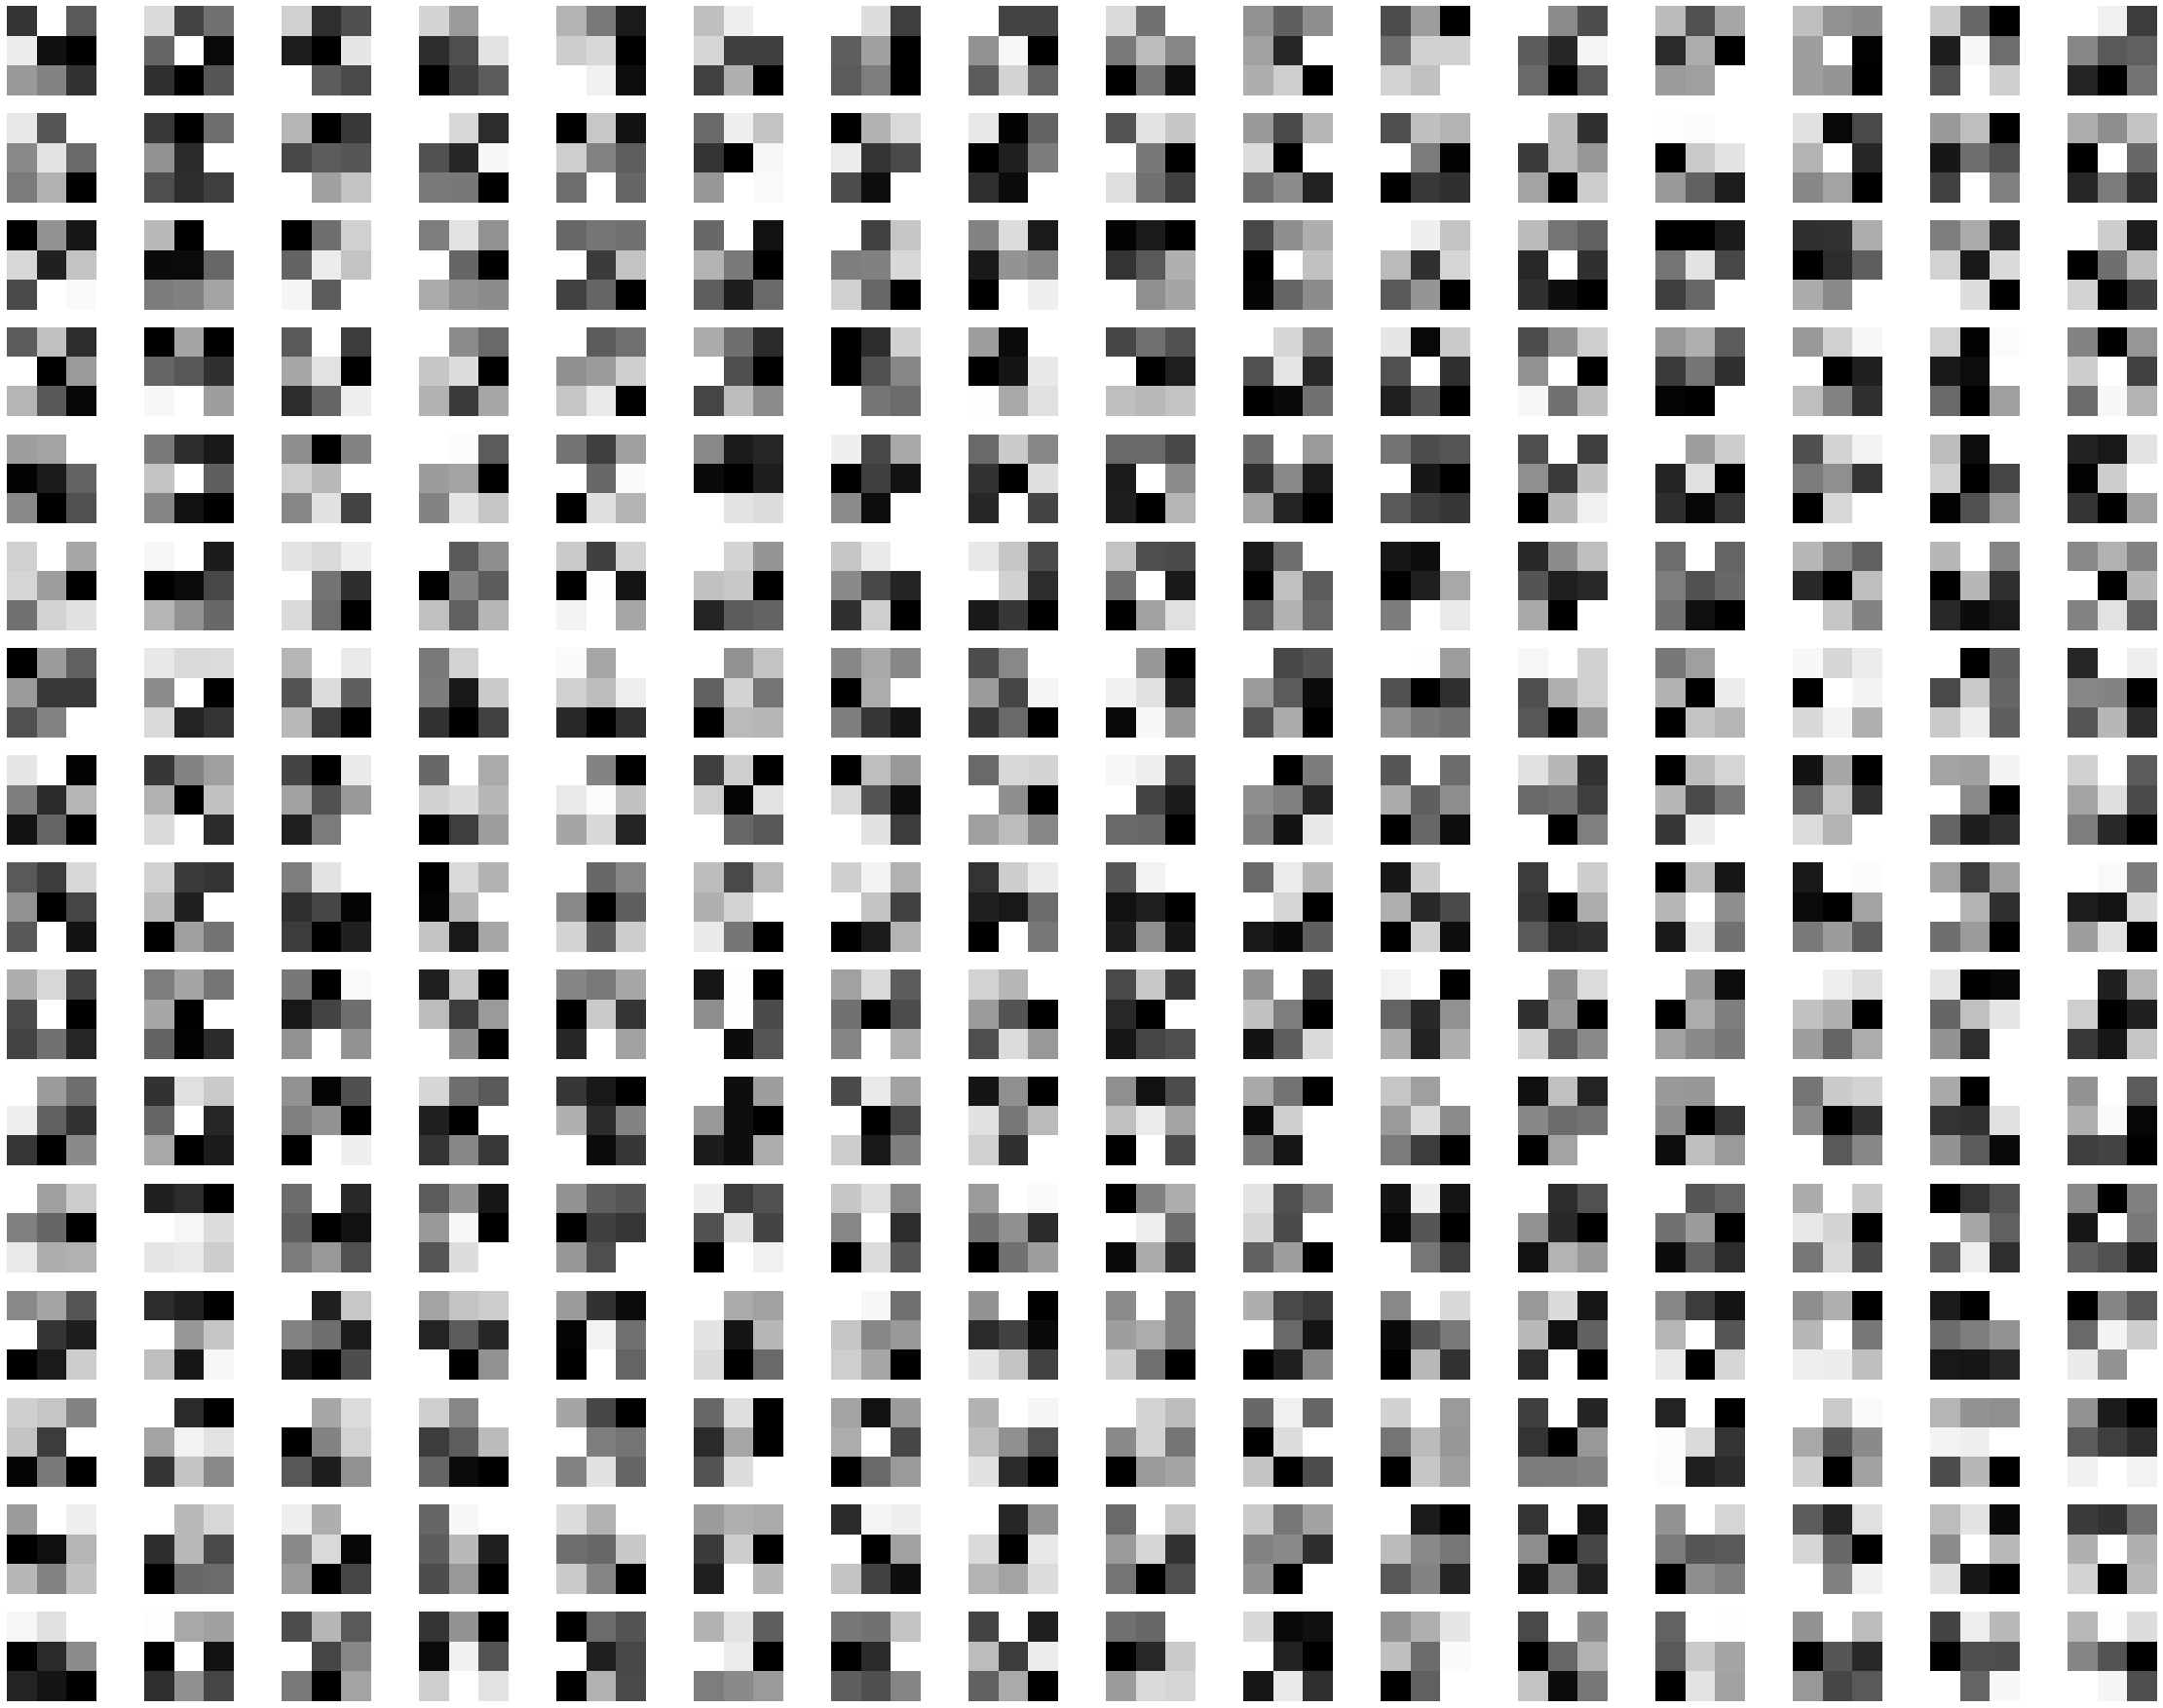

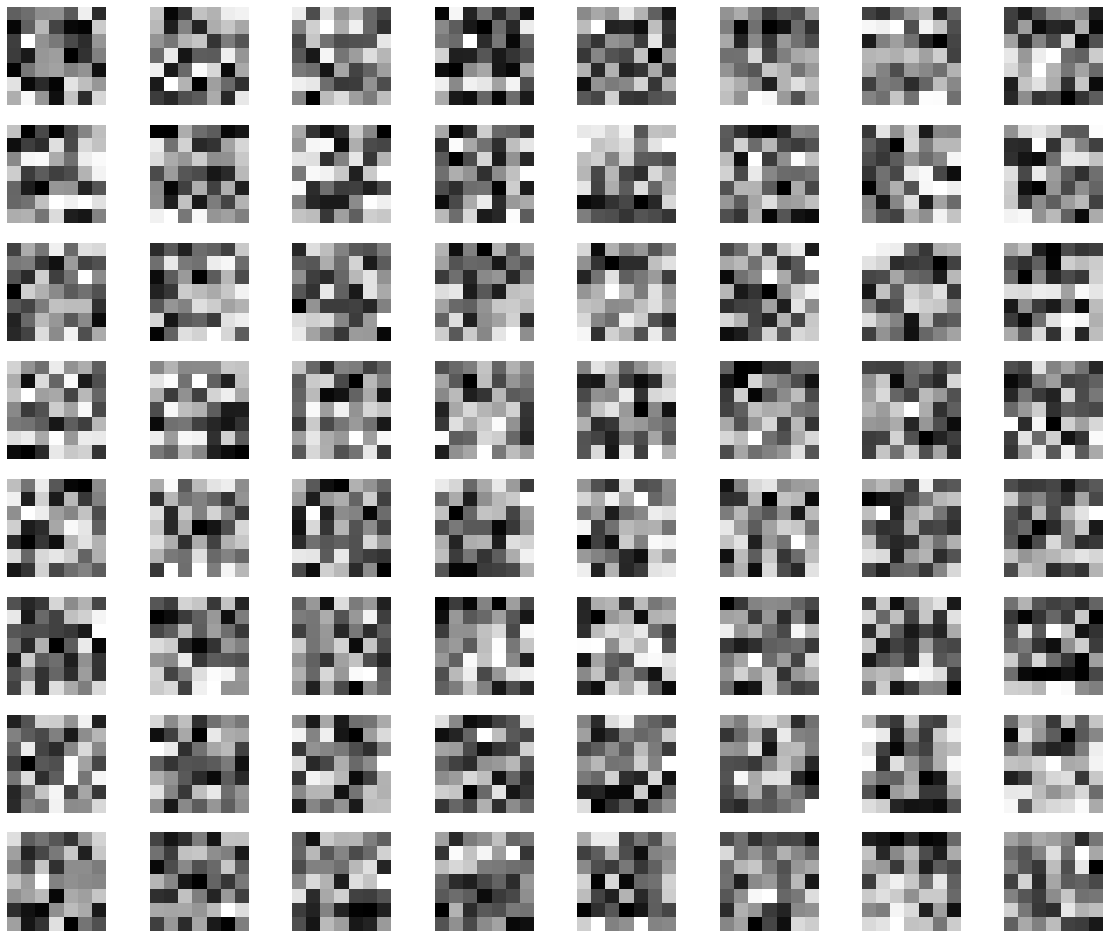

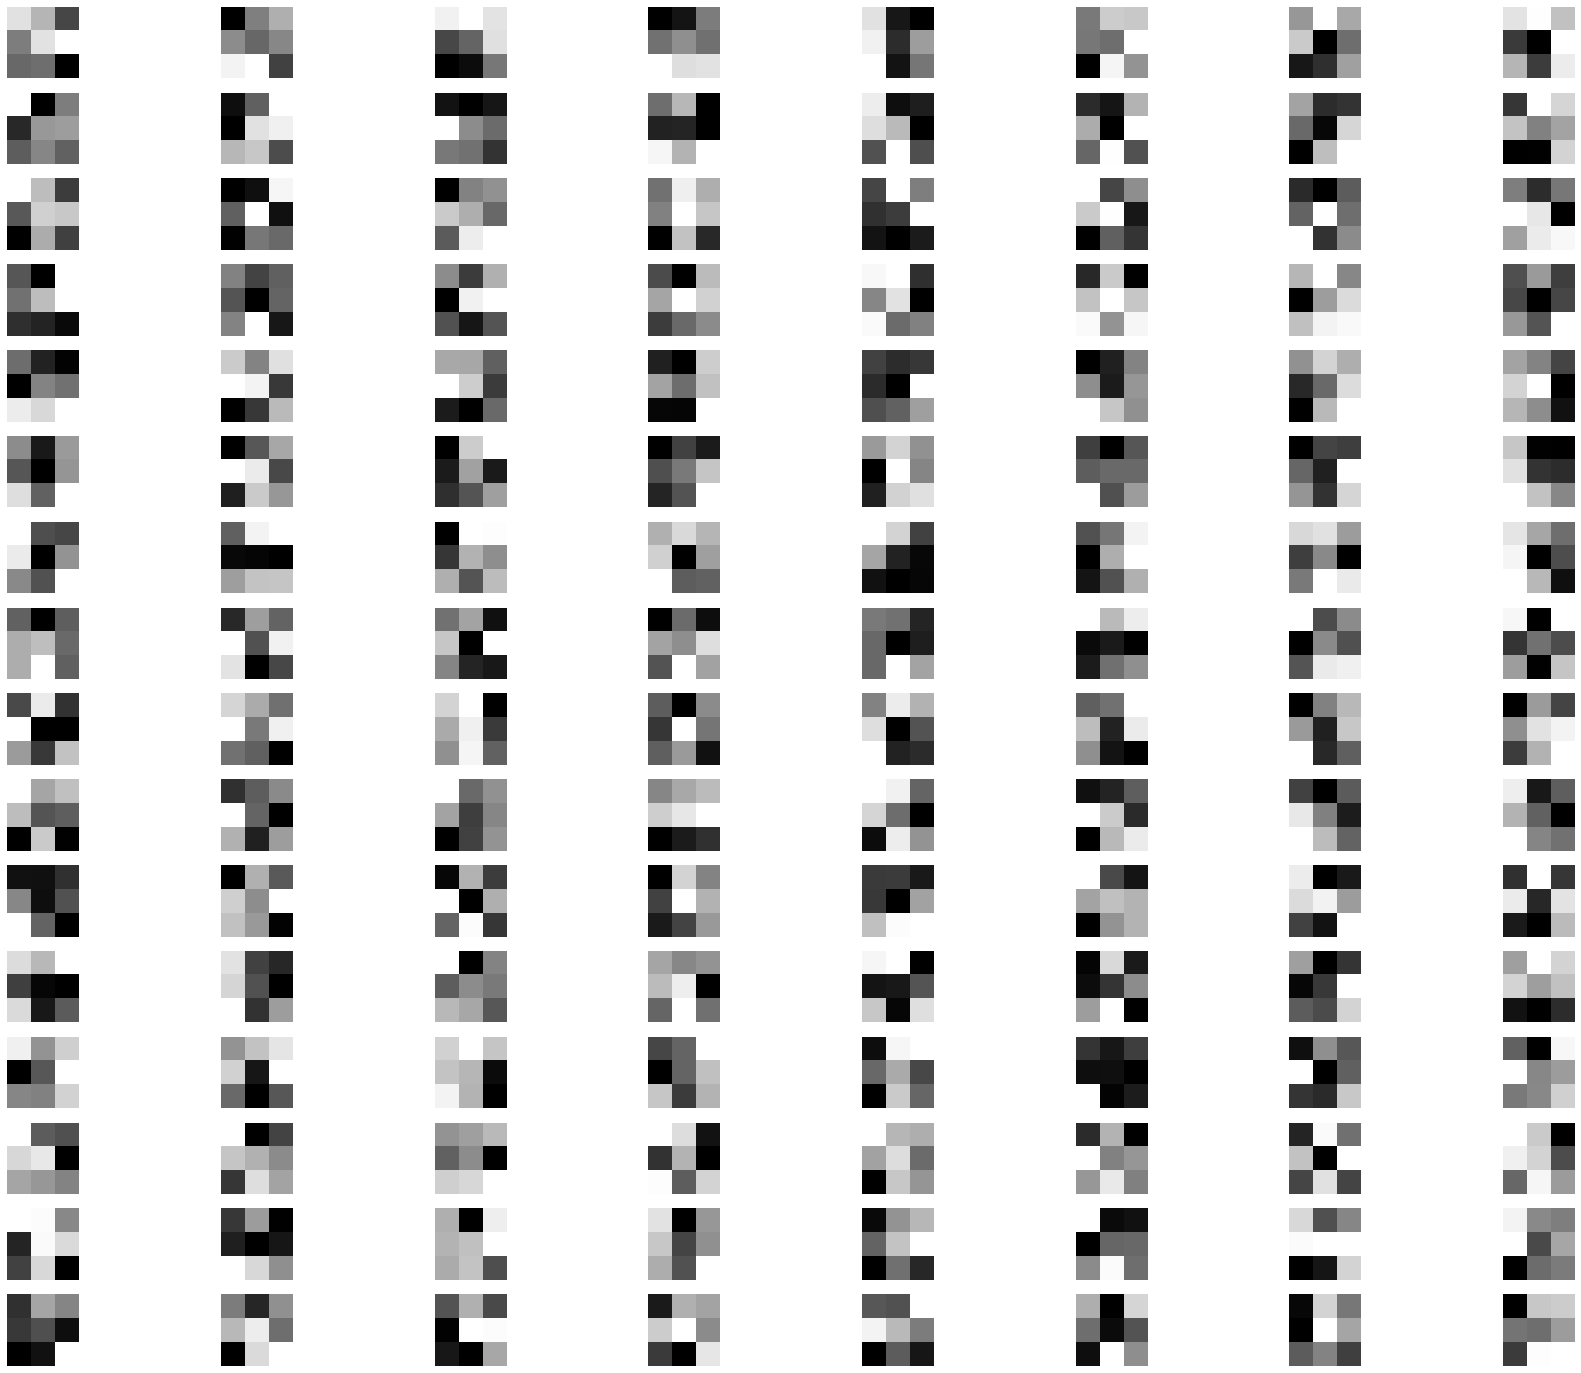

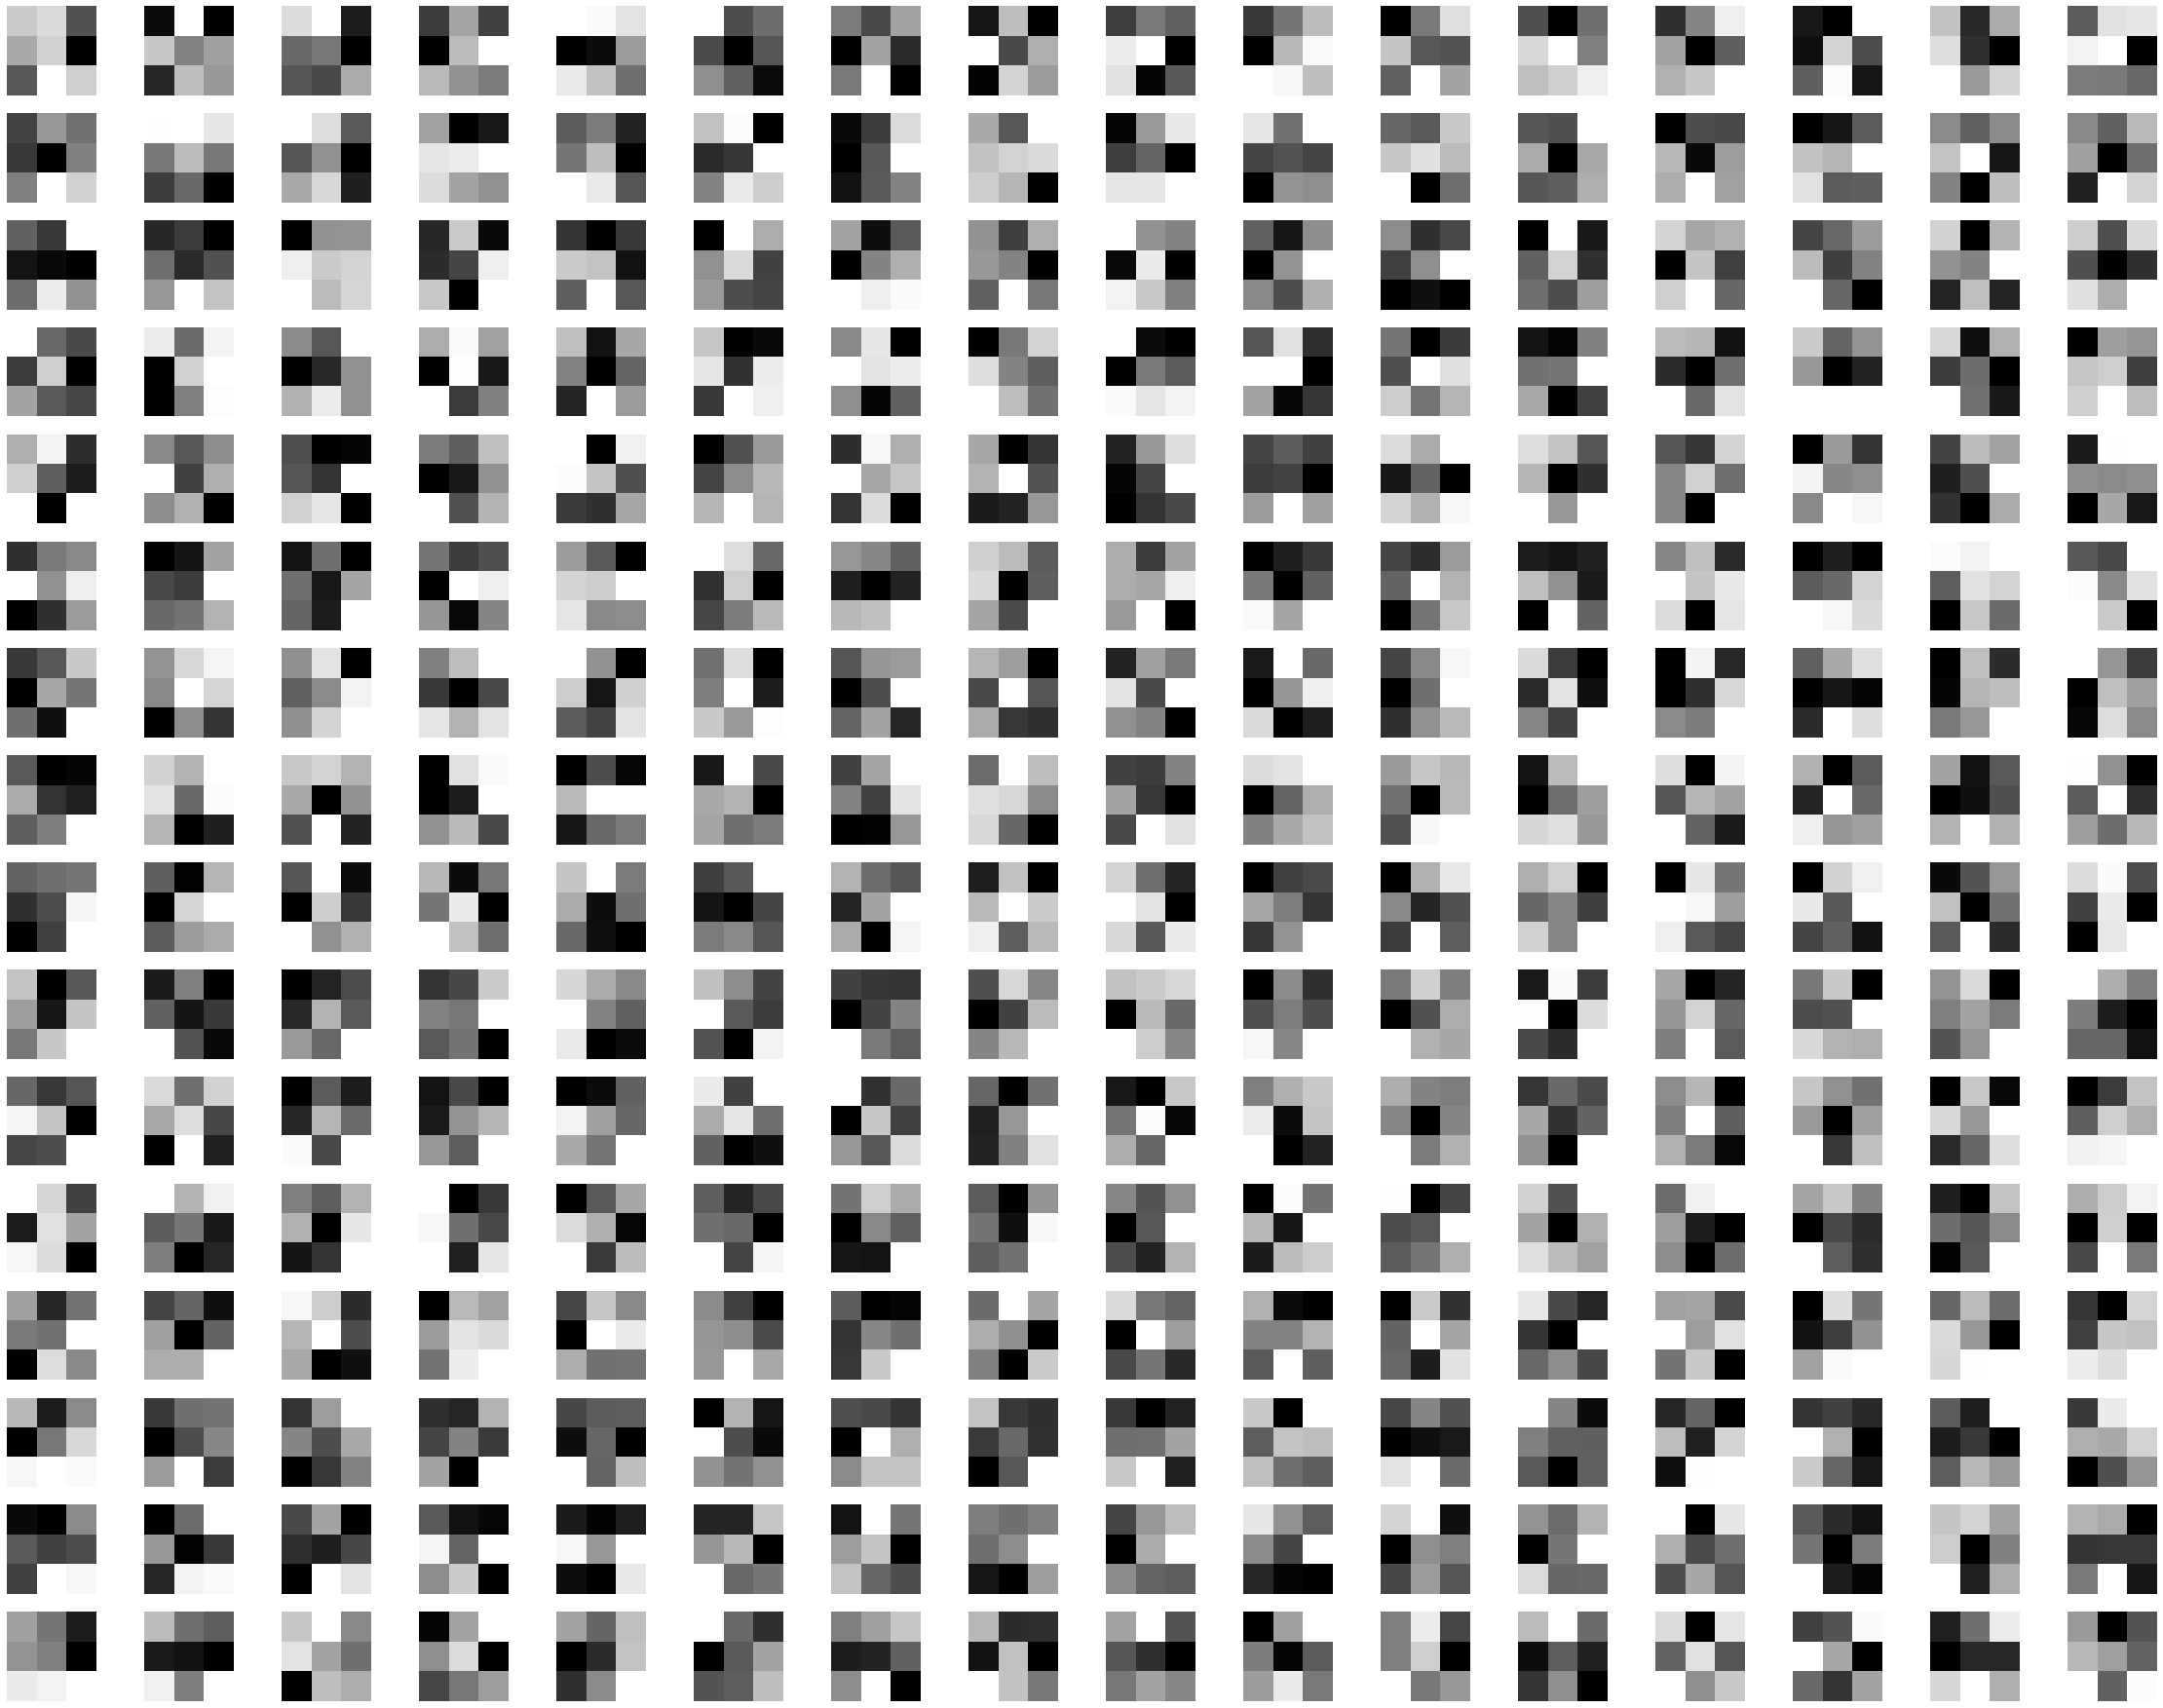

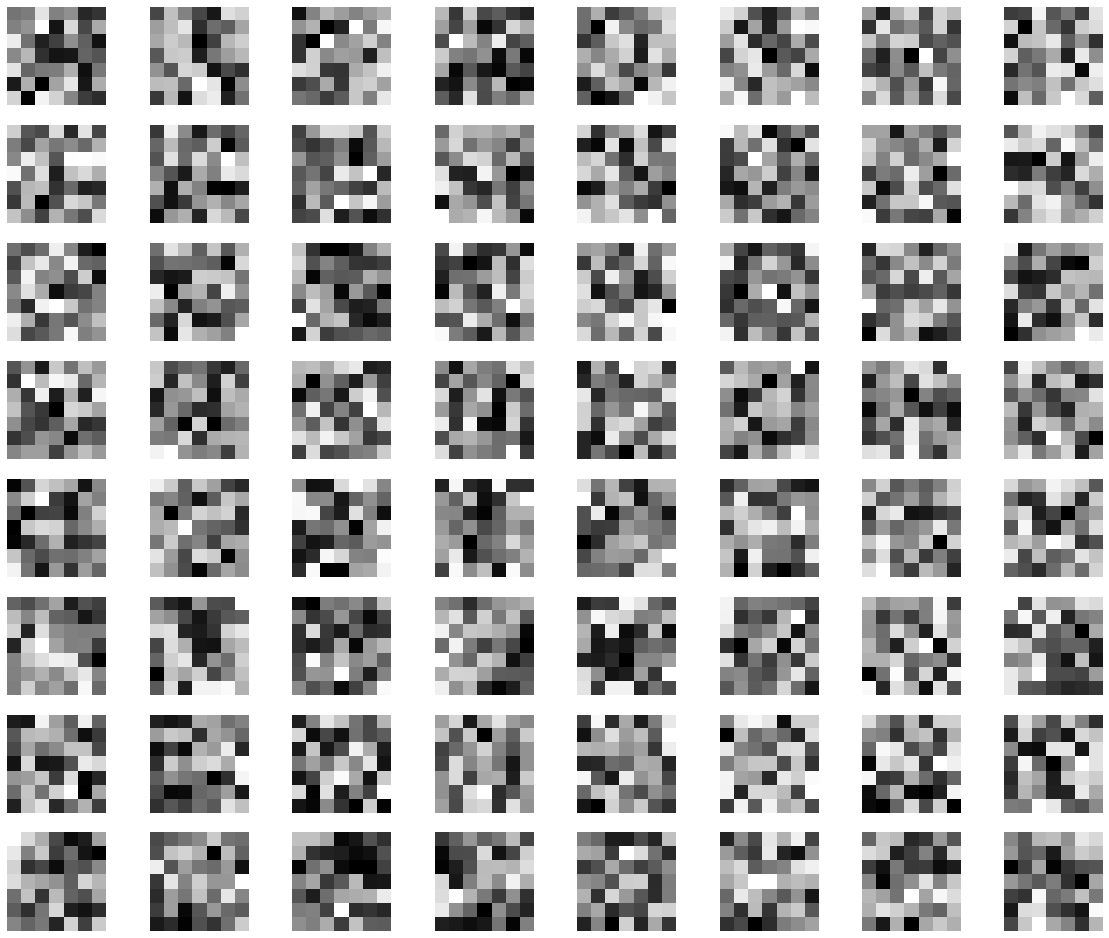

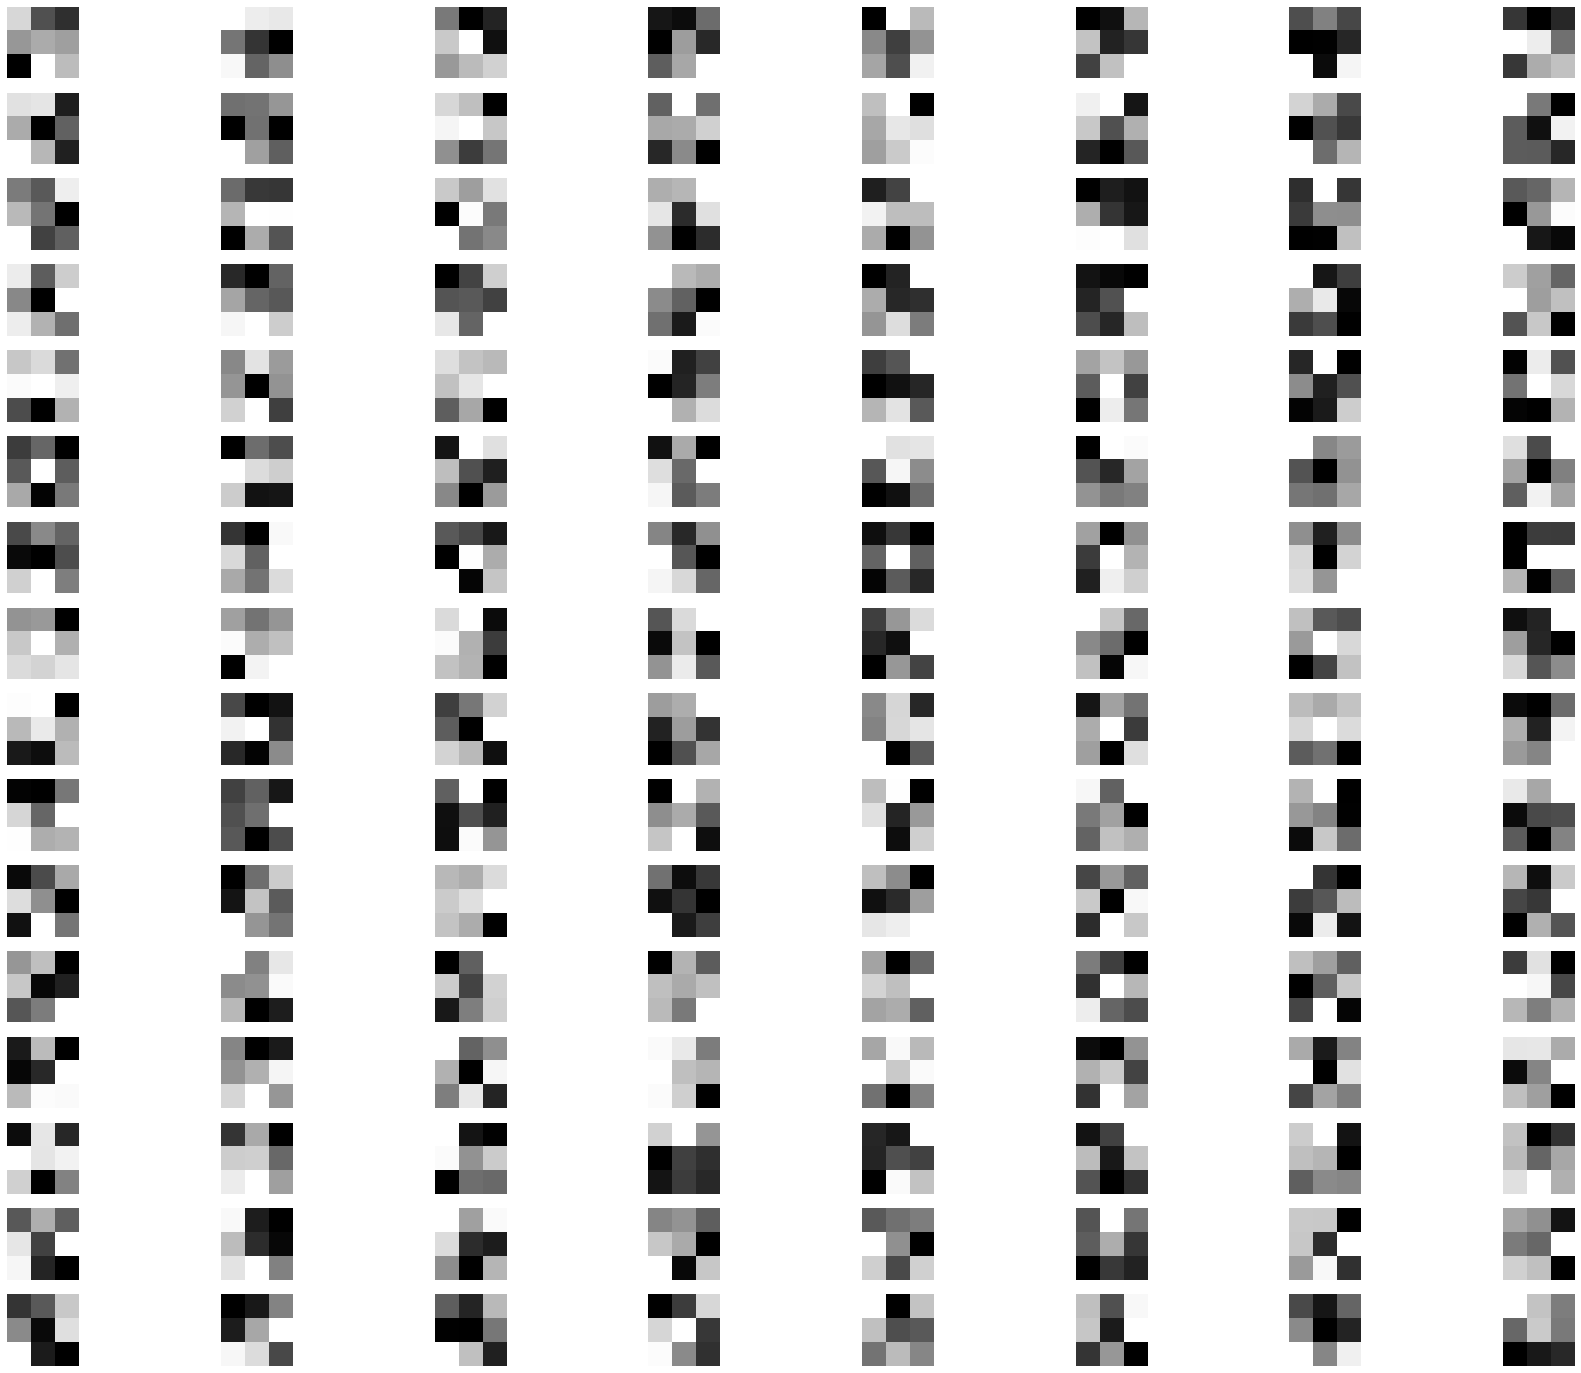

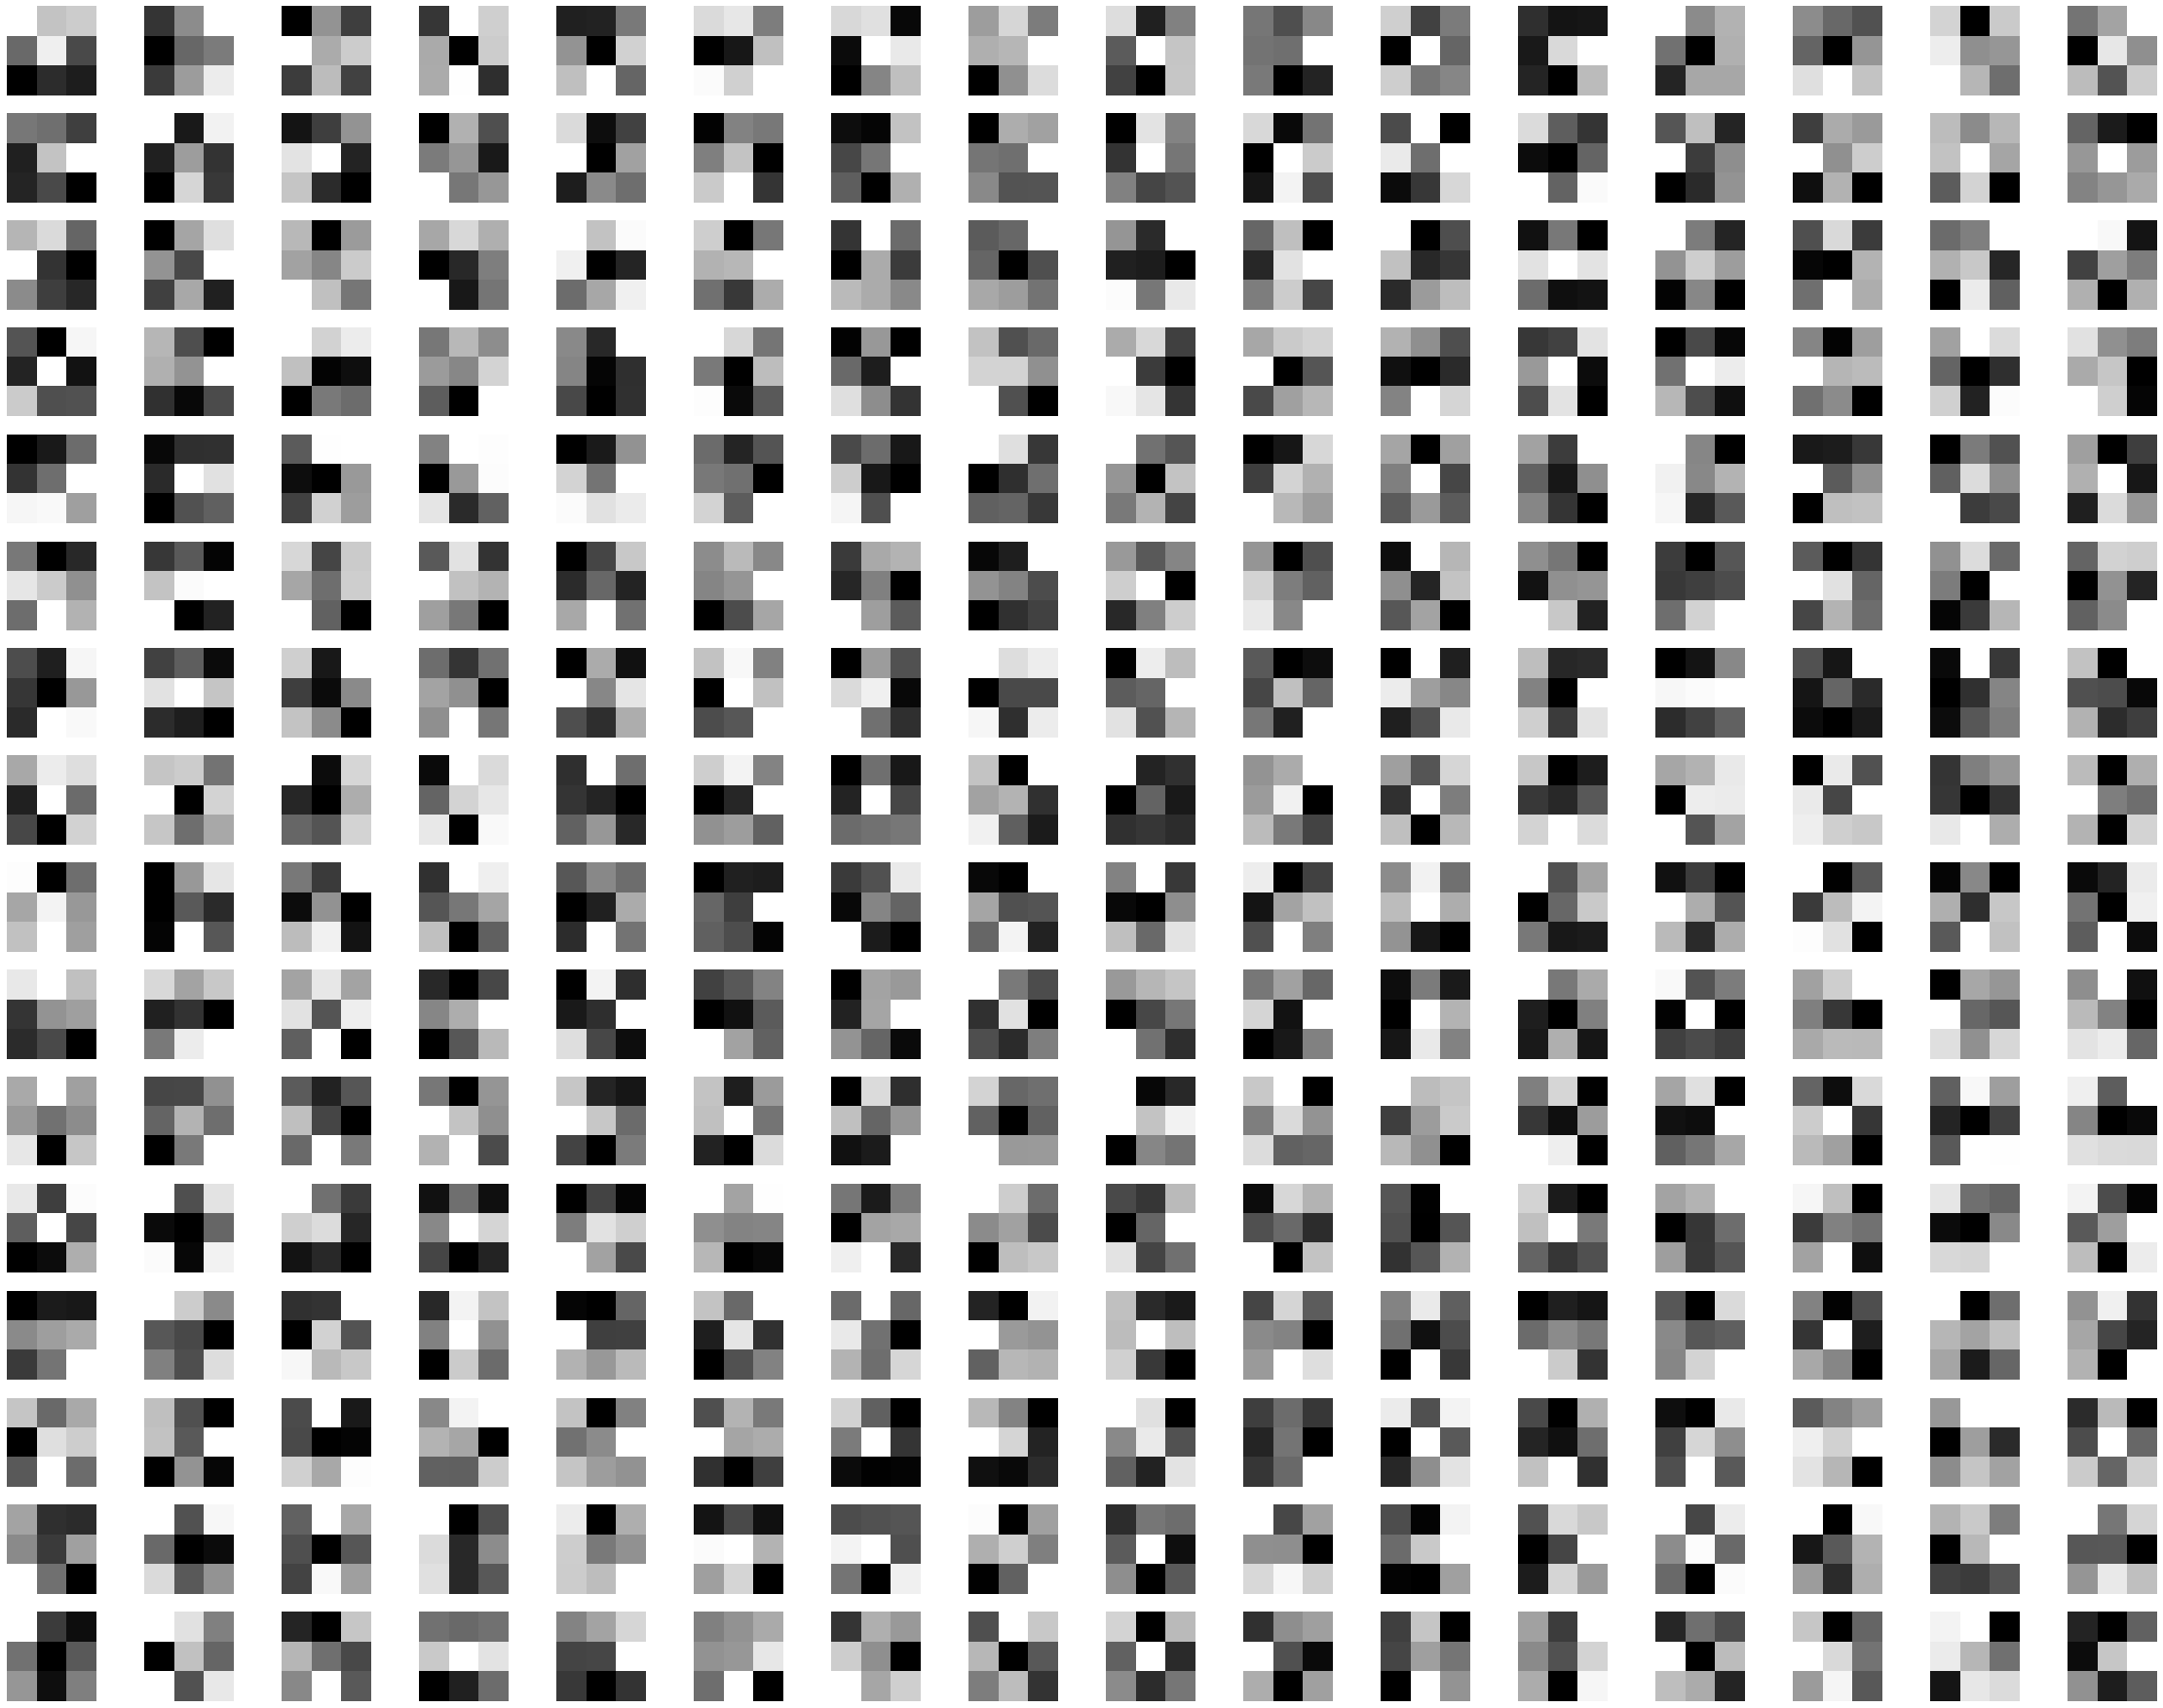

In [27]:
model.plotFilter(where='first', data_type='spec', when='after_train')
model.plotFilter(where='middle', data_type='spec', when='after_train')
model.plotFilter(where='last', data_type='spec', when='after_train')
model.plotFilter(where='first', data_type='mfcc', when='after_train')
model.plotFilter(where='middle', data_type='mfcc', when='after_train')
model.plotFilter(where='last', data_type='mfcc', when='after_train')
model.plotFilter(where='first', data_type='chroma', when='after_train')
model.plotFilter(where='middle', data_type='chroma', when='after_train')
model.plotFilter(where='last', data_type='chroma', when='after_train')

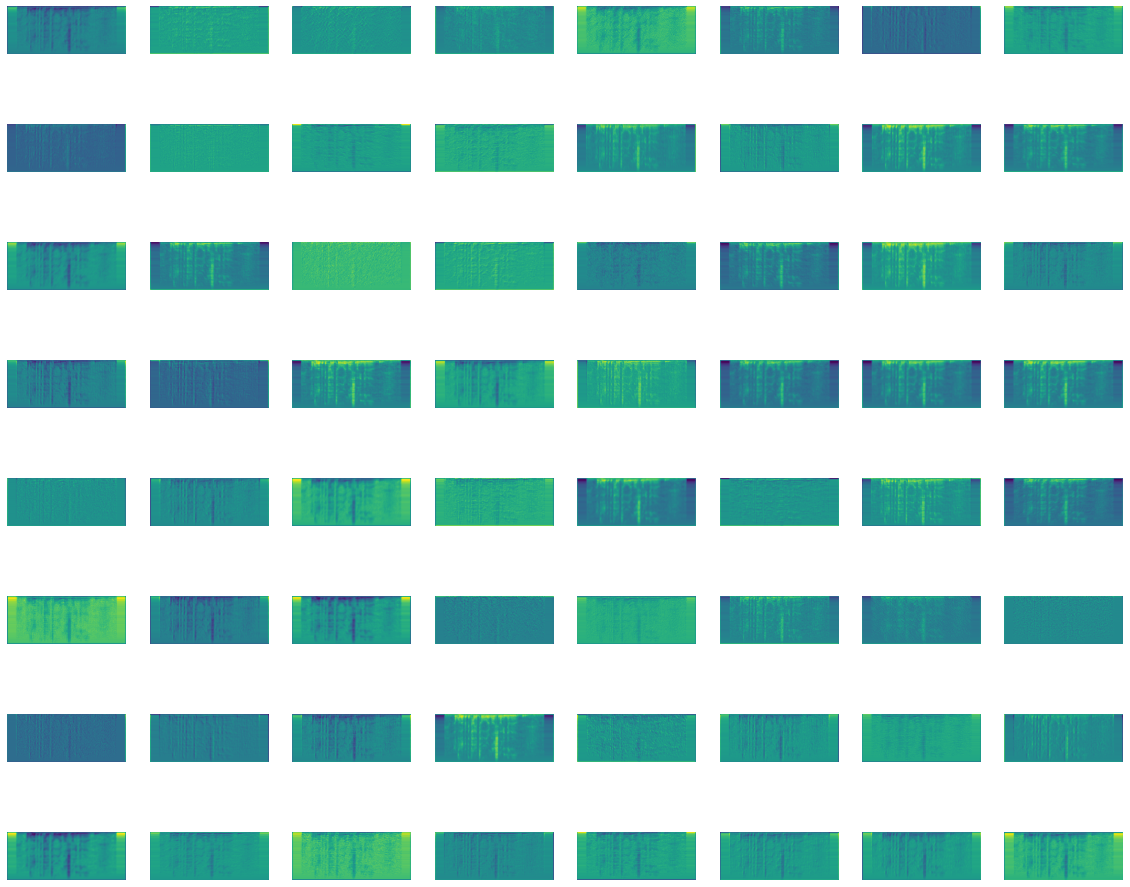

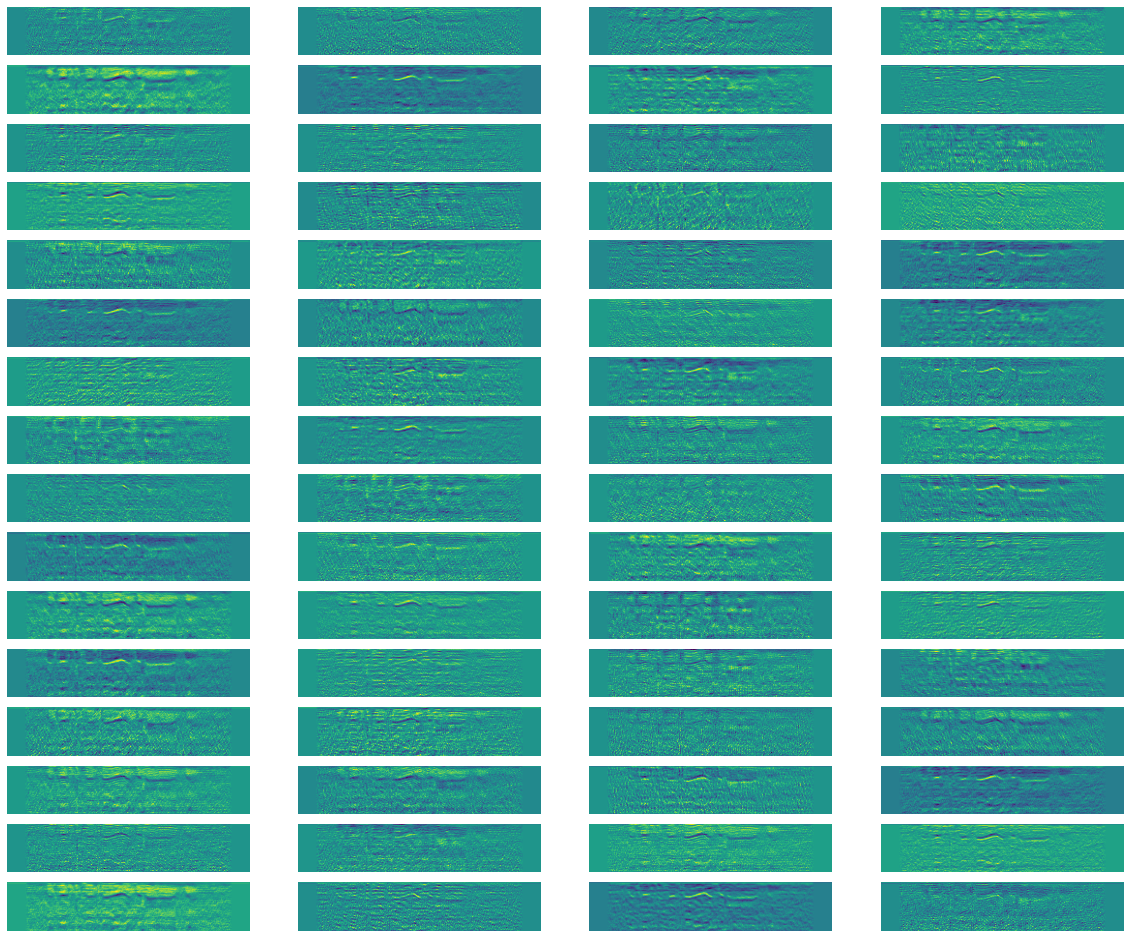

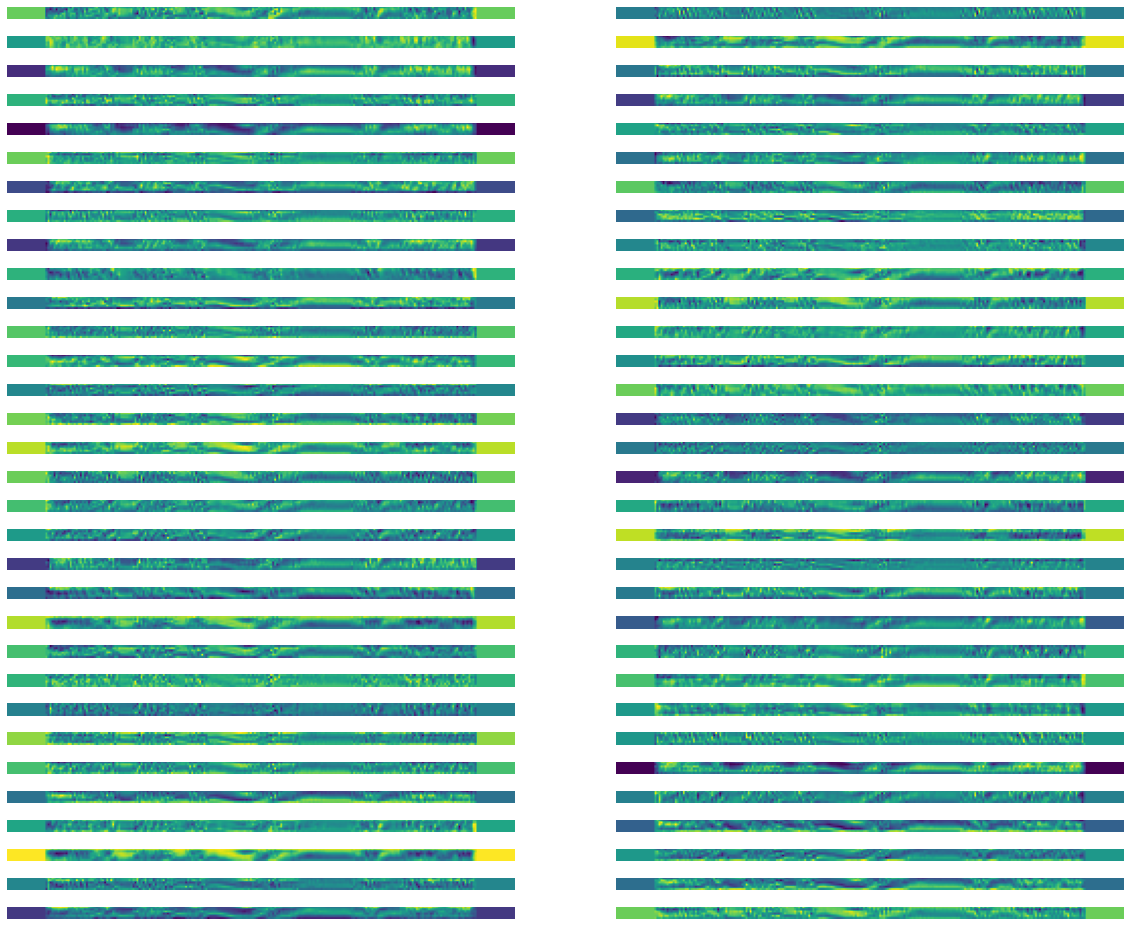

In [28]:
model.plotFeatureMap(dataset[0][0][0].to(device), data_type='spec', when='after_train')
model.plotFeatureMap(dataset[0][0][1].to(device), data_type='mfcc', when='after_train')
model.plotFeatureMap(dataset[0][0][2].to(device), data_type='chroma', when='after_train')